# Introduction

**Name: Enggar Kristian**

**Cermati Recruitment Test: Data Science**

**Objective: To follow up on the recruitment process, we have a written assignment for you to do. We hope you don't mind to finish the test before we can proceed with the interviews.**

1. (70 point) For most financial institutions, such as banks and multi-finance companies, their main source of income is coming from their lending activities. By engaging in this activity, it means that lenders are exposed to the potential risk, where debtors stop repaying their loans, causing losses to the lenders. To mitigate this loss, lenders are expected to appropriately choose who are qualified for a loan, at what rate, and at what amount.  
In this question, you are tasked to help the troubled lenders with this problem by creating a model that can help them make their decision. The lenders also provided the following dataset that you can use, which are attached in DS1.zip in the email (columns description is provided in the columns_description.csv, 
unnamed columns in the given dataset can be dropped):
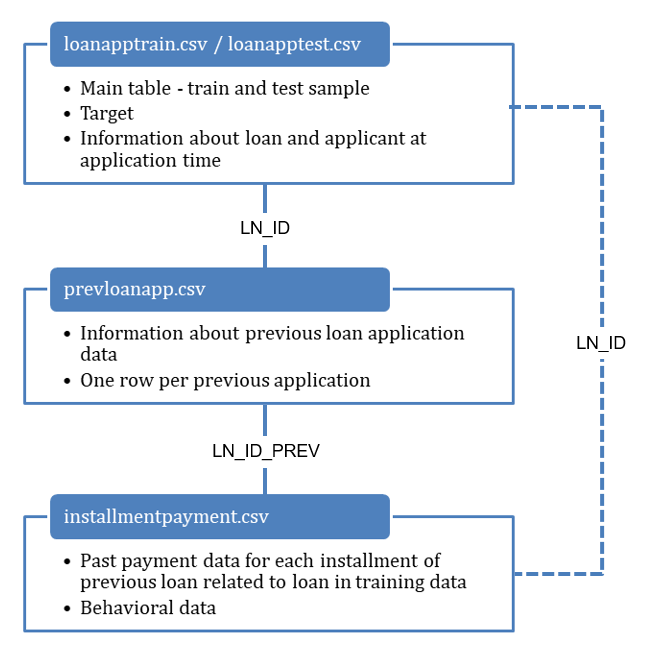

Given the dataset above, please create a model to rank the loan applicants based on their repayment capability. The rank will then be used to choose who are eligible for a loan, lower interest rate and higher credit limit. Consider the following points when you are creating the model:
  - (10 point) Describe the data pre-processing step that you did
  - (5 point) Choose the most appropriate metrics to measure the model performance and provide explanation on why you choose them
  - (30 point) Choose 3 of the most important features (original or derived features) and explain how and why they are important
  - (15 point) Choose the most appropriate model and provide explanation on why and how the model can solve the lenders problem
  - (10 point) Submit the model and all the analysis that you made complete with the test set result (Accuracy, Precision/Recall, F1, AUC, etc)

2. (20 point) A software company is trying to assess their marketing strategy by sending 2 types of marketing emails : business-style email and consumer-style email. We want to see which marketing strategy does better, based on how the emails make user interested in clicking-through. Below are the graphs representing the result of the experiment, The bottom two graphs has the same data as the top two, but binned by the amount of money they spend with the company the year before this emails were sent. Which Campaign did better and why?

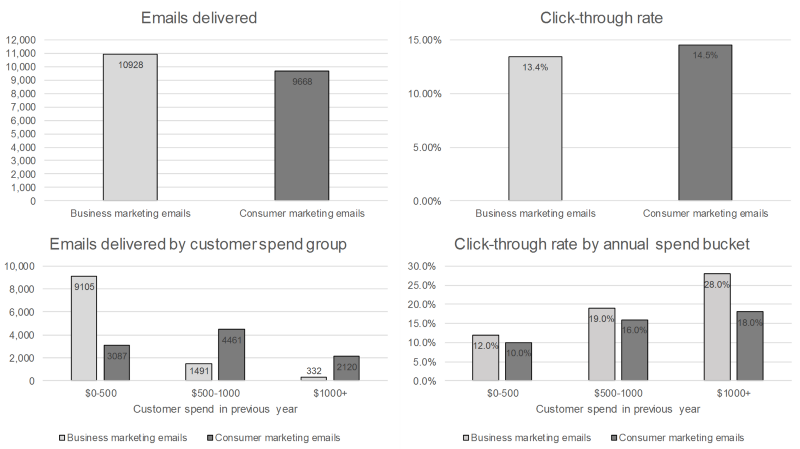

3. (10 point) What could be some issues if the distribution of the test data is significantly different than the distribution of the training data?


# 1 - Answer Number 1

## Import Libraries

I did modeling with Google Colab.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# masuk folder "model_ml_dl"
% cd /content/gdrive/MyDrive/data_science_test/cermati

/content/gdrive/MyDrive/data_science_test/cermati


In [3]:
# Check folder 
!ls

 app_test.csv		     installment_payment.csv
 app_train.csv		     models
 columns_description.csv     prev_app.csv
'Data Scientist Test.docx'  '~$ta Scientist Test.docx'
 DS1.zip


In [103]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from plotly.offline import init_notebook_mode, iplot

# Useful functions

import joblib

import warnings
warnings.filterwarnings('ignore')

# For Handling Missing Values
!pip install feature_engine
from feature_engine.imputation import CategoricalImputer
from feature_engine.outliers import OutlierTrimmer
from sklearn.impute import SimpleImputer

# For Data Preprocessing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# For Classification Problems
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Evaluate Classification Models
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

# Hypothesis Testing 
from scipy.stats import ttest_ind

# display all columns
pd.set_option('display.max_columns',500)

pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='Set1')

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Useful Package

In [5]:
def check_unique(data, col_type='both'):
    """
    Count the number of unique values in each features for 'numeric', 'categorical', or 'both'

    Parameters
    ----------
    data : DataFrame

    col_type : str
        The type of the column to filter. Either 'number', 'object', or 'both'

    Returns
    -------
    DataFrame
        Number of unique values of each features
    """

    # check if the column type is valid
    if col_type not in ('number', 'object', 'both'):
        raise ValueError('col_type must be either "number", "object", or "both"')

    # create a list if the column type is 'both'
    if col_type == 'both':
        col_type = ['number', 'object']

    # get the number of unique values in each column
    data_unique_count = pd.DataFrame.from_records(
        [(col, data[col].nunique()) for col in data.select_dtypes(include=col_type).columns],
        columns=['feats', 'num_unique']
    )
    data_unique_count['pct_unique'] = data_unique_count['num_unique'] / data.shape[0] * 100

    return data_unique_count

In [6]:
def check_missing(data):
    """
    Check the missing values in dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Missing values in dataset
    """

    # create a DataFrame to store the missing values
    data_missing = pd.DataFrame(data.isna().sum().sort_values(ascending=False), columns=['tot_missing']).reset_index()

    # reset the index and make the features columns
    data_missing = data_missing.rename(columns={'index': 'feats'})

    # drop the rows with no missing values
    data_missing = data_missing[data_missing['tot_missing'] > 0]

    # calculate the percentage of missing values for each features
    data_missing['tot_missing_pct'] = data_missing['tot_missing'] / len(data) * 100

    return data_missing

In [7]:
def prepare_imputation(data, variable, *args):
    """
    Prepare data for imputation

    Parameters
    ----------
    data : pandas.DataFrame
        Dataframe to be prepared for imputation
    variable : list
        List of columns to be imputed
    *args :
        List of special keywords representing the missing values

    Returns
    -------
    pandas.DataFrame
        Dataframe prepared for imputation
    """

    if data is None or variable is None:
        raise ValueError('data and variable must be specified')
    
    # prepare output dataframe
    output_data = data.copy()

    # replace missval with nan for features in impute_cols
    for col in variable:
        for missval in args:
            output_data[col] = output_data[col].replace(missval, np.nan)

    return output_data

In [8]:
def find_normal_boundaries(data, variable):
    """
    Calculate the boundaries outside which sit the outliers for a Gaussian distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    upper_boundary = data[variable].mean() + 3 * data[variable].std()
    lower_boundary = data[variable].mean() - 3 * data[variable].std()

    return upper_boundary, lower_boundary

In [9]:
def find_skewed_boundaries(data, variable, distance):
    """
    Calculate the boundaries outside which sit the outliers for skewed distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    distance : float
        The distance multiplier of IQR to calculate the boundaries

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)

    upper_boundary = data[variable].quantile(0.75) + (IQR * distance)
    lower_boundary = data[variable].quantile(0.25) - (IQR * distance)

    return upper_boundary, lower_boundary

In [10]:
def check_dist(data):
    """
    Check the Skewness and Distribution for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Skewness and distribution types of each features
    """

    # create a DataFrame containing the features of the dataset and their respective skewness
    data_skewness = pd.DataFrame(data.skew(), columns=['skew']).reset_index()

    # reset the index and make the features columns
    data_skewness = data_skewness.rename(columns={'index': 'feats'})

    # create a new column to describe whether the feature in the dataset is normal or skewed
    data_skewness['dist'] = np.where(
        (data_skewness['skew'] > -0.5) & (data_skewness['skew'] < 0.5),
        'normal',
        'skewed'
    )

    return data_skewness

In [11]:
def check_outlier(data, distance=1.5):
    """
    Check the outlier info for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Outlier infos such as upper and lower boundary, and also the number of outliers for each features
    """

    if distance not in (1.5, 3):
        raise ValueError('Parameter distance only accepts numeric value of either 1.5 or 3')

    data_skewness = check_dist(data)

    # create a dictionary to store the outlier infos
    data_outlier = {
        'feats': [],
        'upper_bound': [],
        'lower_bound': [],
        'tot_right_tail': [],
        'tot_left_tail': [],
        'tot_right_tail_pct': [],
        'tot_left_tail_pct': [],
        'tot_outlier': [],
        'tot_outlier_pct': [],
    }

    # loop over each row in the `skewness` DataFrame
    # calculate each features upper and lower boundaries and the outlier percentage
    for row in data_skewness.index:
        col = data_skewness.iloc[row]['feats']

        if data_skewness.iloc[row]['dist'] == 'normal':
            upper_bound, lower_bound = find_normal_boundaries(data, col)
        else:
            upper_bound, lower_bound = find_skewed_boundaries(data, col, distance)

        tot_right_tail = len(data[data[col] > upper_bound])
        tot_left_tail = len(data[data[col] < lower_bound])
        tot_right_tail_pct = tot_right_tail / len(data) * 100
        tot_left_tail_pct = tot_left_tail / len(data) * 100
        tot_outlier =  tot_right_tail + tot_left_tail
        tot_outlier_pct = tot_right_tail_pct + tot_left_tail_pct

        data_outlier['feats'].append(col)
        data_outlier['upper_bound'].append(upper_bound)
        data_outlier['lower_bound'].append(lower_bound)
        data_outlier['tot_right_tail'].append(tot_right_tail)
        data_outlier['tot_left_tail'].append(tot_left_tail)
        data_outlier['tot_right_tail_pct'].append(tot_right_tail_pct)
        data_outlier['tot_left_tail_pct'].append(tot_left_tail_pct)
        data_outlier['tot_outlier'].append(tot_outlier)
        data_outlier['tot_outlier_pct'].append(tot_outlier_pct)
    
    data_outlier = pd.DataFrame(data_outlier)

    return data_outlier

In [12]:
def outlier_summary(data, distance=1.5):
    """
    Check the summary for outlier data, such as distribution and number of outliers for each features

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Summary of outlier such as distribution and number of outliers for each features
    """

    data_skewness = check_dist(data)
    data_outlier = check_outlier(data, distance)

    outlier_summary_cols = ['feats', 'skew', 'dist', 'tot_outlier', 'tot_outlier_pct']

    data_outlier_summary = pd.merge(data_skewness, data_outlier, on=['feats'])
    data_outlier_summary = data_outlier_summary[outlier_summary_cols]

    return data_outlier_summary

In [13]:
def trim_cap_outliers(data, exception_list=[], target=None, distance=1.5):
    """
    Function to trim outliers based on the cap outliers

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame to trim outliers
    exception_list : list
        List of features to be excluded from trimming
    target : pandas Series or DataFrame
        Target variable name
    distance : float
        Distance multiplier to define the cap

    Returns
    -------
    data : pandas DataFrame
        Trimmed data
    if target is not None:
        target : pandas Series or DataFrame
            Trimmed target variable
    """

    # define whether to adjust target
    adjust_target = False
    if target is not None:
        adjust_target = True

    # run outlier detection
    data_outlier = outlier_summary(data, distance)

    # create a list of columns to trim outliers for normal distribution
    norm_trim_cols = data_outlier[
        (data_outlier['dist'] == 'normal') &
        (data_outlier['tot_outlier_pct'] < 5)
    ]['feats'].to_list()

    # create a list of columns to cap outliers for normal distribution
    norm_cap_cols = data_outlier[
        (data_outlier['dist'] == 'normal') &
        (data_outlier['tot_outlier_pct'] >= 5) &
        (data_outlier['tot_outlier_pct'] < 15)
    ]['feats'].to_list()

    # create a list of columns to trim outliers for skew distribution
    skew_trim_cols = data_outlier[
        (data_outlier['dist'] == 'skewed') &
        (data_outlier['tot_outlier_pct'] < 5)
    ]['feats'].to_list()

    # create a list of columns to cap outliers for skew distribution
    skew_cap_cols = data_outlier[
        (data_outlier['dist'] == 'skewed') &
        (data_outlier['tot_outlier_pct'] >= 5) &
        (data_outlier['tot_outlier_pct'] < 15)
    ]['feats'].to_list()


    # remove exception columns from the list
    norm_trim_cols = [x for x in norm_trim_cols if x not in exception_list]
    norm_cap_cols = [x for x in norm_cap_cols if x not in exception_list]
    skew_trim_cols = [x for x in skew_trim_cols if x not in exception_list]
    skew_cap_cols = [x for x in skew_cap_cols if x not in exception_list]


    # outlier trimming for normal distribution
    if len(norm_trim_cols) > 0:
        trim_norm = OutlierTrimmer(
            capping_method='gaussian',
            tail='both',
            fold=3,
            variables=norm_trim_cols,
            missing_values='ignore'
        )

        # trim outliers for normal distribution
        data = trim_norm.fit_transform(data)

        # adjust target to match the features
        if adjust_target:
            target = target.drop(target.index.difference(data.index))


    # outlier capping for normal distribution
    if len(norm_cap_cols) > 0:
        cap_norm = Winsorizer(
            capping_method='gaussian',
            tail='both',
            fold=3,
            variables=norm_cap_cols,
            missing_values='ignore'
        )

        # cap outliers for normal distribution
        data = cap_norm.fit_transform(data)


    # outlier trimming for skewed distribution
    if len(skew_trim_cols) > 0:
        trim_skew = OutlierTrimmer(
            capping_method='iqr',
            tail='both',
            fold=1.5,
            variables=skew_trim_cols,
            missing_values='ignore'
        )

        # trim outliers for skewed distribution
        data = trim_skew.fit_transform(data)

        # adjust target to match the features
        if adjust_target:
            target = target.drop(target.index.difference(data.index))


    # outlier capping for skewed distribution
    if len(skew_cap_cols) > 0:
        cap_skew = Winsorizer(
            capping_method='iqr',
            tail='both',
            fold=1.5,
            variables=skew_cap_cols,
            missing_values='ignore'
        )

        # cap outliers for skewed distribution
        data = cap_skew.fit_transform(data)


    if adjust_target:
        return data, target
    else:
        return data

In [14]:
def impute_na(data, variable, mean_value, median_value):
  """
  Function to Fill Missing Values with Zeroes, Mean, and Median
  """
  data[variable+'_mean'] = data[variable].fillna(mean_value)
  data[variable+'_median'] = data[variable].fillna(median_value)
  data[variable+'_zero'] = data[variable].fillna(0)
  
  return data

## Data Loading

Dataset has been uploaded to my drive so i will cal all dataset from my google drive.

In [15]:
# Load data train-test sample
data_loan_train = pd.read_csv("/content/gdrive/MyDrive/data_science_test/cermati/app_train.csv")
data_loan_test = pd.read_csv("/content/gdrive/MyDrive/data_science_test/cermati/app_test.csv")

# Load data prevloan
data_prevloan_app = pd.read_csv("/content/gdrive/MyDrive/data_science_test/cermati/prev_app.csv")

# Load data installment payment
data_ins_pay = pd.read_csv("/content/gdrive/MyDrive/data_science_test/cermati/installment_payment.csv")

## Data Train

In [16]:
# Call the top five data train
data_loan_train.head()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
0,201468,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,0.57,0.61,NaN
1,264803,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,0.66,0.68,NaN
2,137208,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1,NaN,0.58,0.75
3,269220,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,NaN,0.62,0.71
4,122096,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,0.18,0.49,0.09


In [17]:
data_loan_train.tail()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
61498,130325,251159,0,Cash loans,M,2,360000.0,450000.0,44509.5,450000.0,State servant,Secondary / secondary special,Married,House / apartment,-14268,-5813,-2313.0,-2709,FRIDAY,6,Electricity,0.30,0.10,0.62
61499,294665,441376,1,Cash loans,F,0,441000.0,904500.0,38452.5,904500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21582,365243,-4106.0,-4191,TUESDAY,12,NA1,0.69,0.41,0.24
61500,73002,184648,0,Revolving loans,F,0,202500.0,900000.0,45000.0,900000.0,Commercial associate,Higher education,Married,House / apartment,-17729,-1564,-11844.0,-1263,FRIDAY,16,Industry: type 12,0.80,0.71,NaN
61501,184610,313981,0,Cash loans,F,0,94500.0,360000.0,17509.5,360000.0,Working,Secondary / secondary special,Married,House / apartment,-11258,-4159,-5060.0,-3698,FRIDAY,15,Business Entity Type 3,NaN,0.69,0.11
61502,166652,293198,0,Cash loans,F,0,90000.0,203760.0,20281.5,180000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-24604,365243,-12794.0,-4105,TUESDAY,11,NA1,NaN,0.25,0.64


In [18]:
# Want to know real size all dataset
data_loan_train.shape

(61503, 24)

We have 61503 rows and 24 features for training data, we hope from this data can build best model.

In [19]:
data_loan_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,61503.0,153729.99,88881.48,6.00e+00,76545.50,153893.00,230884.50,3.08e+05
LN_ID,61503.0,278151.14,102918.21,1.00e+05,188767.00,278357.00,367424.50,4.56e+05
TARGET,61503.0,0.08,0.27,0.00e+00,0.00,0.00,0.00,1.00e+00
NUM_CHILDREN,61503.0,0.41,0.72,0.00e+00,0.00,0.00,1.00,9.00e+00
INCOME,61503.0,169078.87,133969.66,2.61e+04,112500.00,148500.00,202500.00,1.80e+07
APPROVED_CREDIT,61503.0,597689.92,401649.35,4.50e+04,270000.00,512446.50,808650.00,4.05e+06
ANNUITY,61502.0,27083.32,14470.51,2.16e+03,16506.00,24853.50,34596.00,2.58e+05
PRICE,61441.0,536903.32,368574.22,4.50e+04,238500.00,450000.00,679500.00,4.05e+06
DAYS_AGE,61503.0,-16057.48,4363.54,-2.52e+04,-19716.50,-15753.00,-12450.00,-7.67e+03
DAYS_WORK,61503.0,64882.26,142154.44,-1.79e+04,-2761.00,-1208.00,-276.00,3.65e+05


In [20]:
data_loan_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         61503 non-null  int64  
 1   LN_ID              61503 non-null  int64  
 2   TARGET             61503 non-null  int64  
 3   CONTRACT_TYPE      61503 non-null  object 
 4   GENDER             61503 non-null  object 
 5   NUM_CHILDREN       61503 non-null  int64  
 6   INCOME             61503 non-null  float64
 7   APPROVED_CREDIT    61503 non-null  float64
 8   ANNUITY            61502 non-null  float64
 9   PRICE              61441 non-null  float64
 10  INCOME_TYPE        61503 non-null  object 
 11  EDUCATION          61503 non-null  object 
 12  FAMILY_STATUS      61503 non-null  object 
 13  HOUSING_TYPE       61503 non-null  object 
 14  DAYS_AGE           61503 non-null  int64  
 15  DAYS_WORK          61503 non-null  int64  
 16  DAYS_REGISTRATION  615

This raw dataset many missing values in their features need to handle missing values and there's column Unnamed that i don't know what it is, it might be drop column Unnamed adn LN_ID, also column EXT_SCORE_1 have a extreme missing value, if i fill it's not proper better drop.

In [21]:
# Copy dataset that can use to modification dataset
data_copy_loan_train = data_loan_train.copy() 

In [22]:
data_copy_loan_train.columns

Index(['Unnamed: 0', 'LN_ID', 'TARGET', 'CONTRACT_TYPE', 'GENDER',
       'NUM_CHILDREN', 'INCOME', 'APPROVED_CREDIT', 'ANNUITY', 'PRICE',
       'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS', 'HOUSING_TYPE', 'DAYS_AGE',
       'DAYS_WORK', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'WEEKDAYS_APPLY',
       'HOUR_APPLY', 'ORGANIZATION_TYPE', 'EXT_SCORE_1', 'EXT_SCORE_2',
       'EXT_SCORE_3'],
      dtype='object')

In [23]:
data_copy_loan_train.drop(columns=['Unnamed: 0', 'LN_ID', 'EXT_SCORE_1'], axis=1, inplace=True)
data_copy_loan_train.head()

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_2,EXT_SCORE_3
0,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,0.61,NaN
1,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,0.68,NaN
2,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1,0.58,0.75
3,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,0.62,0.71
4,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,0.49,0.09


Well the Data Train ready for to clean!

In [24]:
# removing space and change into "_" in column name
data_copy_loan_train.columns = data_copy_loan_train.columns.str.replace(' ', '_')
# Column names: remove white spaces and convert to lower case
data_copy_loan_train.columns= data_copy_loan_train.columns.str.strip().str.lower()
data_copy_loan_train.head()

,target,contract_type,gender,num_children,income,approved_credit,annuity,price,income_type,education,family_status,housing_type,days_age,days_work,days_registration,days_id_change,weekdays_apply,hour_apply,organization_type,ext_score_2,ext_score_3
0,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,0.61,NaN
1,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,0.68,NaN
2,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1,0.58,0.75
3,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,0.62,0.71
4,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,0.49,0.09


In [25]:
# As dataset having lot of extra spaces in cell so lets remove them using replace() function
data_copy_loan_train['contract_type'] = data_copy_loan_train['contract_type'].str.replace(' ', '').str.lower()
data_copy_loan_train['income_type'] = data_copy_loan_train['income_type'].str.replace(' ', '').str.lower()
data_copy_loan_train['education'] = data_copy_loan_train['education'].str.replace(' ', '').str.lower()
data_copy_loan_train['family_status'] = data_copy_loan_train['family_status'].str.replace(' ', '').str.lower()
data_copy_loan_train['housing_type'] = data_copy_loan_train['housing_type'].str.replace(' ', '').str.lower()
data_copy_loan_train['weekdays_apply'] = data_copy_loan_train['weekdays_apply'].str.replace(' ', '').str.lower()
data_copy_loan_train['organization_type'] = data_copy_loan_train['organization_type'].str.replace(' ', '').str.lower()

In [26]:
data_copy_loan_train

,target,contract_type,gender,num_children,income,approved_credit,annuity,price,income_type,education,family_status,housing_type,days_age,days_work,days_registration,days_id_change,weekdays_apply,hour_apply,organization_type,ext_score_2,ext_score_3
0,0,revolvingloans,F,1,67500.0,202500.0,10125.0,202500.0,working,secondary/secondaryspecial,married,withparents,-11539,-921,-119.0,-2757,tuesday,18,businessentitytype3,0.61,NaN
1,0,cashloans,F,1,202500.0,976711.5,49869.0,873000.0,commercialassociate,secondary/secondaryspecial,married,house/apartment,-15743,-4482,-1797.0,-2455,tuesday,14,other,0.68,NaN
2,0,cashloans,F,0,180000.0,407520.0,25060.5,360000.0,pensioner,secondary/secondaryspecial,married,house/apartment,-20775,365243,-8737.0,-4312,thursday,14,na1,0.58,0.75
3,0,cashloans,M,0,225000.0,808650.0,26086.5,675000.0,stateservant,highereducation,married,house/apartment,-20659,-10455,-4998.0,-4010,wednesday,10,culture,0.62,0.71
4,0,revolvingloans,M,0,135000.0,180000.0,9000.0,180000.0,commercialassociate,secondary/secondaryspecial,single/notmarried,house/apartment,-9013,-1190,-3524.0,-1644,sunday,11,construction,0.49,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,0,cashloans,M,2,360000.0,450000.0,44509.5,450000.0,stateservant,secondary/secondaryspecial,married,house/apartment,-14268,-5813,-2313.0,-2709,friday,6,electricity,0.10,0.62
61499,1,cashloans,F,0,441000.0,904500.0,38452.5,904500.0,pensioner,secondary/secondaryspecial,married,house/apartment,-21582,365243,-4106.0,-4191,tuesday,12,na1,0.41,0.24
61500,0,revolvingloans,F,0,202500.0,900000.0,45000.0,900000.0,commercialassociate,highereducation,married,house/apartment,-17729,-1564,-11844.0,-1263,friday,16,industry:type12,0.71,NaN
61501,0,cashloans,F,0,94500.0,360000.0,17509.5,360000.0,working,secondary/secondaryspecial,married,house/apartment,-11258,-4159,-5060.0,-3698,friday,15,businessentitytype3,0.69,0.11


## Data Test

In [27]:
# Call the top five data test
data_loan_test.head()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
0,102590,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,Secondary / secondary special,Married,House / apartment,-17598,-2650,-1411.0,-1131,SATURDAY,7,Business Entity Type 3,NaN,0.15,0.65
1,35895,141577,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,Higher education,Married,Office apartment,-14097,-7408,-7908.0,-4872,MONDAY,14,Kindergarten,NaN,0.68,NaN
2,69154,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,Secondary / secondary special,Married,House / apartment,-18384,-2826,-8226.0,-1930,SATURDAY,12,Self-employed,0.81,0.69,0.76
3,222185,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,Secondary / secondary special,Married,House / apartment,-12170,-926,-916.0,-4048,THURSDAY,13,Other,0.40,0.27,0.06
4,147680,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,Incomplete higher,Married,House / apartment,-10790,-577,-4640.0,-2035,MONDAY,14,Business Entity Type 3,0.37,0.61,0.39


In [28]:
data_loan_test.tail()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
14756,38250,144293,0,Cash loans,F,1,67500.0,1.12e+05,7317.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-12866,-3154,-1251.0,-4395,TUESDAY,10,Government,0.57,0.40,0.59
14757,148422,272093,1,Cash loans,F,1,135000.0,3.13e+05,21073.5,283500.0,Working,Secondary / secondary special,Civil marriage,With parents,-11421,-3962,-5247.0,-3795,SATURDAY,7,Self-employed,NaN,0.61,0.37
14758,130286,251117,0,Cash loans,F,0,157500.0,1.08e+06,31522.5,900000.0,State servant,Higher education,Separated,House / apartment,-13313,-2258,-3899.0,-4515,MONDAY,12,Other,NaN,0.64,0.78
14759,202131,334313,0,Cash loans,F,0,216000.0,2.73e+05,21658.5,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-24085,365243,-9354.0,-4740,THURSDAY,15,NA1,NaN,0.64,0.58
14760,101569,217927,0,Cash loans,F,3,112500.0,2.61e+05,20299.5,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-12782,-387,-1261.0,-4823,THURSDAY,9,Self-employed,NaN,0.38,0.52


In [29]:
# Want to know real size all dataset
data_loan_test.shape

(14761, 24)

In [30]:
data_loan_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,14761.0,154253.86,88185.63,4.70e+01,78418.00,154391.00,230217.00,3.08e+05
LN_ID,14761.0,278759.50,102112.47,1.00e+05,190910.00,278940.00,366655.00,4.56e+05
TARGET,14761.0,0.08,0.27,0.00e+00,0.00,0.00,0.00,1.00e+00
NUM_CHILDREN,14761.0,0.41,0.71,0.00e+00,0.00,0.00,1.00,5.00e+00
INCOME,14761.0,167496.48,95387.66,2.66e+04,112500.00,144000.00,202500.00,2.93e+06
APPROVED_CREDIT,14761.0,596131.80,399686.13,4.50e+04,270000.00,509400.00,808650.00,4.05e+06
ANNUITY,14761.0,27127.50,14473.65,2.19e+03,16654.50,24822.00,34573.50,1.78e+05
PRICE,14741.0,536192.91,366519.35,4.50e+04,238500.00,450000.00,679500.00,4.05e+06
DAYS_AGE,14761.0,-16024.98,4369.32,-2.52e+04,-19705.00,-15682.00,-12381.00,-7.69e+03
DAYS_WORK,14761.0,65527.06,142694.98,-1.64e+04,-2784.00,-1221.00,-275.00,3.65e+05


In [31]:
data_loan_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14761 entries, 0 to 14760
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         14761 non-null  int64  
 1   LN_ID              14761 non-null  int64  
 2   TARGET             14761 non-null  int64  
 3   CONTRACT_TYPE      14761 non-null  object 
 4   GENDER             14761 non-null  object 
 5   NUM_CHILDREN       14761 non-null  int64  
 6   INCOME             14761 non-null  float64
 7   APPROVED_CREDIT    14761 non-null  float64
 8   ANNUITY            14761 non-null  float64
 9   PRICE              14741 non-null  float64
 10  INCOME_TYPE        14761 non-null  object 
 11  EDUCATION          14761 non-null  object 
 12  FAMILY_STATUS      14761 non-null  object 
 13  HOUSING_TYPE       14761 non-null  object 
 14  DAYS_AGE           14761 non-null  int64  
 15  DAYS_WORK          14761 non-null  int64  
 16  DAYS_REGISTRATION  147

Also dataset test many missing values in their features need to handle missing values and there's column Unnamed that i don't know what it is, it might be drop column Unnamed adn LN_ID, also column EXT_SCORE_1 have a extreme missing value, if i fill it's not proper better drop.

In [32]:
# Copy dataset that can use to modification dataset
data_copy_loan_test = data_loan_test.copy() 

In [33]:
data_copy_loan_test.columns

Index(['Unnamed: 0', 'LN_ID', 'TARGET', 'CONTRACT_TYPE', 'GENDER',
       'NUM_CHILDREN', 'INCOME', 'APPROVED_CREDIT', 'ANNUITY', 'PRICE',
       'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS', 'HOUSING_TYPE', 'DAYS_AGE',
       'DAYS_WORK', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'WEEKDAYS_APPLY',
       'HOUR_APPLY', 'ORGANIZATION_TYPE', 'EXT_SCORE_1', 'EXT_SCORE_2',
       'EXT_SCORE_3'],
      dtype='object')

In [34]:
data_copy_loan_test.drop(columns=['Unnamed: 0', 'LN_ID', 'EXT_SCORE_1'], axis=1, inplace=True)
data_copy_loan_test.head()

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_2,EXT_SCORE_3
0,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,Secondary / secondary special,Married,House / apartment,-17598,-2650,-1411.0,-1131,SATURDAY,7,Business Entity Type 3,0.15,0.65
1,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,Higher education,Married,Office apartment,-14097,-7408,-7908.0,-4872,MONDAY,14,Kindergarten,0.68,NaN
2,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,Secondary / secondary special,Married,House / apartment,-18384,-2826,-8226.0,-1930,SATURDAY,12,Self-employed,0.69,0.76
3,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,Secondary / secondary special,Married,House / apartment,-12170,-926,-916.0,-4048,THURSDAY,13,Other,0.27,0.06
4,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,Incomplete higher,Married,House / apartment,-10790,-577,-4640.0,-2035,MONDAY,14,Business Entity Type 3,0.61,0.39


Well the Data Test ready for to clean!

In [35]:
# removing space and change into "_" in column name
data_copy_loan_test.columns = data_copy_loan_test.columns.str.replace(' ', '_')
# Column names: remove white spaces and convert to lower case
data_copy_loan_test.columns= data_copy_loan_test.columns.str.strip().str.lower()
data_copy_loan_test.head()

,target,contract_type,gender,num_children,income,approved_credit,annuity,price,income_type,education,family_status,housing_type,days_age,days_work,days_registration,days_id_change,weekdays_apply,hour_apply,organization_type,ext_score_2,ext_score_3
0,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,Secondary / secondary special,Married,House / apartment,-17598,-2650,-1411.0,-1131,SATURDAY,7,Business Entity Type 3,0.15,0.65
1,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,Higher education,Married,Office apartment,-14097,-7408,-7908.0,-4872,MONDAY,14,Kindergarten,0.68,NaN
2,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,Secondary / secondary special,Married,House / apartment,-18384,-2826,-8226.0,-1930,SATURDAY,12,Self-employed,0.69,0.76
3,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,Secondary / secondary special,Married,House / apartment,-12170,-926,-916.0,-4048,THURSDAY,13,Other,0.27,0.06
4,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,Incomplete higher,Married,House / apartment,-10790,-577,-4640.0,-2035,MONDAY,14,Business Entity Type 3,0.61,0.39


In [36]:
# As dataset having lot of extra spaces in cell so lets remove them using replace() function
data_copy_loan_test['contract_type'] = data_copy_loan_test['contract_type'].str.replace(' ', '').str.lower()
data_copy_loan_test['income_type'] = data_copy_loan_test['income_type'].str.replace(' ', '').str.lower()
data_copy_loan_test['education'] = data_copy_loan_test['education'].str.replace(' ', '').str.lower()
data_copy_loan_test['family_status'] = data_copy_loan_test['family_status'].str.replace(' ', '').str.lower()
data_copy_loan_test['housing_type'] = data_copy_loan_test['housing_type'].str.replace(' ', '').str.lower()
data_copy_loan_test['weekdays_apply'] = data_copy_loan_test['weekdays_apply'].str.replace(' ', '').str.lower()
data_copy_loan_test['organization_type'] = data_copy_loan_test['organization_type'].str.replace(' ', '').str.lower()

In [37]:
data_copy_loan_test

,target,contract_type,gender,num_children,income,approved_credit,annuity,price,income_type,education,family_status,housing_type,days_age,days_work,days_registration,days_id_change,weekdays_apply,hour_apply,organization_type,ext_score_2,ext_score_3
0,0,cashloans,M,3,135000.0,8.71e+05,44604.0,765000.0,working,secondary/secondaryspecial,married,house/apartment,-17598,-2650,-1411.0,-1131,saturday,7,businessentitytype3,0.15,0.65
1,0,cashloans,F,0,144000.0,4.86e+05,34537.5,450000.0,working,highereducation,married,officeapartment,-14097,-7408,-7908.0,-4872,monday,14,kindergarten,0.68,NaN
2,0,cashloans,F,1,90000.0,2.48e+05,8887.5,247500.0,working,secondary/secondaryspecial,married,house/apartment,-18384,-2826,-8226.0,-1930,saturday,12,self-employed,0.69,0.76
3,0,cashloans,M,2,112500.0,5.07e+05,24781.5,418500.0,working,secondary/secondaryspecial,married,house/apartment,-12170,-926,-916.0,-4048,thursday,13,other,0.27,0.06
4,0,cashloans,M,0,216000.0,4.50e+05,21888.0,450000.0,working,incompletehigher,married,house/apartment,-10790,-577,-4640.0,-2035,monday,14,businessentitytype3,0.61,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14756,0,cashloans,F,1,67500.0,1.12e+05,7317.0,112500.0,working,secondary/secondaryspecial,married,house/apartment,-12866,-3154,-1251.0,-4395,tuesday,10,government,0.40,0.59
14757,1,cashloans,F,1,135000.0,3.13e+05,21073.5,283500.0,working,secondary/secondaryspecial,civilmarriage,withparents,-11421,-3962,-5247.0,-3795,saturday,7,self-employed,0.61,0.37
14758,0,cashloans,F,0,157500.0,1.08e+06,31522.5,900000.0,stateservant,highereducation,separated,house/apartment,-13313,-2258,-3899.0,-4515,monday,12,other,0.64,0.78
14759,0,cashloans,F,0,216000.0,2.73e+05,21658.5,225000.0,pensioner,secondary/secondaryspecial,widow,house/apartment,-24085,365243,-9354.0,-4740,thursday,15,na1,0.64,0.58


## Exploratory Data Analysis (EDA)

From this chapter we should know about the dataset with data analysis visualization, then the first we do is concat two dataset.

In [38]:
# concat data train and data test
data_loan = pd.concat([data_copy_loan_train, data_copy_loan_test])

In [39]:
# Know about unique all columns in dataset
for col in data_loan:
    print(f'{col}: {data_loan[col].unique()}')

target: [0 1]
contract_type: ['revolvingloans' 'cashloans']
gender: ['F' 'M']
num_children: [1 0 2 3 4 6 5 8 7 9]
income: [   67500.      202500.      180000.      225000.      135000.
    90000.      112500.      108000.      270000.       63000.
   157500.      126000.      450000.       54000.       81000.
    94500.      166500.      130050.      189000.       99000.
   234000.      121500.       74250.      247500.       45000.
   387000.       85500.      360000.       76500.      193500.
   171000.      391500.      139500.       62100.       49950.
    72000.      315000.      211500.      540000.      153000.
   117000.      184500.      144000.      148500.     1125000.
   252000.      301500.      162000.      207000.      110250.
   292500.      405000.      382500.      130500.       40500.
   122688.      101250.       95400.      216000.       58500.
   751500.       49500.      265500.      132750.      468000.
   337500.       96750.      427500.      103500.      1755

I think there is no anomaly data between type of column with the contents.

### Balance binary classification Data

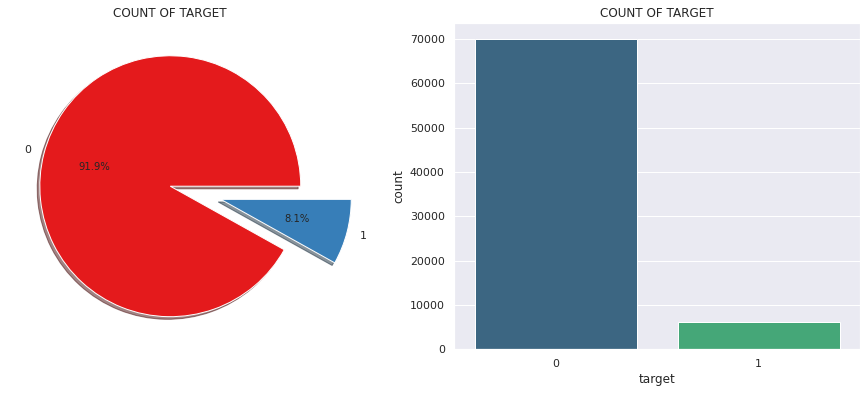

In [53]:
f,ax=plt.subplots(1,2,figsize=(16,6))
data_loan['target'].value_counts().plot.pie(explode=[0,0.4],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[1].set_title('COUNT OF TARGET')
ax[0].set_title('COUNT OF TARGET')
ax[0].set_ylabel('')
sns.countplot('target',data=data_loan,ax=ax[1], palette = 'viridis')
ax[1].set_title('COUNT OF TARGET')
plt.show()

Waw the target is so imbalance data for this case, maybe for improvement model we should have to oversampling dataset. Base on graph we know the case of target type is binary classification.

In [41]:
# Calculating Imbalance percentage
100*(data_loan.target.value_counts())/ (len(data_loan))

0    91.91
1     8.09
Name: target, dtype: float64

We agree that TARGET=0 is our client who has difficulty paying loan, and TARGET=1 is our client who is able or able to pay loan. We look at the percentage that our clients who have difficulty paying are 8% of people and those who are successful are 91.9% of people.

### Contract Type of Applicant's who applied for loan

In [78]:
temp = data_loan["contract_type"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .99]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Types of loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Contract Types",
                "x": 0.50,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

90.4% of Contract Types are dominated by cashloans, as the customer's favorite to borrow.

### Gender of Applicant's who applide for loan

In [81]:
temp = data_loan["gender"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .99]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Gender of applicant's loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Gender",
                "x": 0.50,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

Our customers who become applicants' loans are dominated by women, 65.9%.

### Number of Children client of Applicant's who applied for loan

In [83]:
temp = data_loan["num_children"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .99]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Number of Children of applicant's loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Number of Children",
                "x": 0.50,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

It makes sense that customers who do not have children dominate 70.3%, indeed there is no excessive responsibility, so customers are willing to take risks for loans.

### Income Type of Applicant's who applied for loan

In [84]:
temp = data_loan["income_type"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .99]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Income Type of applicant's loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Income Type",
                "x": 0.50,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

It is precisely those who have worked that become the dominance of the applicant's for loans that allow them to fulfill their primary needs.

### Education of Applicant's who applied for loan

In [85]:
temp = data_loan["education"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .99]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Education of applicant's loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Education",
                "x": 0.50,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

If seen in the graph, it shows that the higher the position of the customer, the less interested they are for a loan.

### Family Status of Applicant's who applied for loan

In [86]:
temp = data_loan["family_status"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .99]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Family Status of applicant's loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Family Status",
                "x": 0.50,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

Many of them are married, who dominate for frequent loans at our place, which makes sense if married customers have many needs that must be met while the incoming income is small.

### Housing Type of Applicnat's who applied for loan

In [87]:
temp = data_loan["housing_type"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .99]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Housing Type of applicant's loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Housing Type",
                "x": 0.50,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

Of the entire client population, most of them live in their own homes or apartments, so it's only natural that they dominate for loans.

### Data Visualization Categorical Columns who have late payment for loan

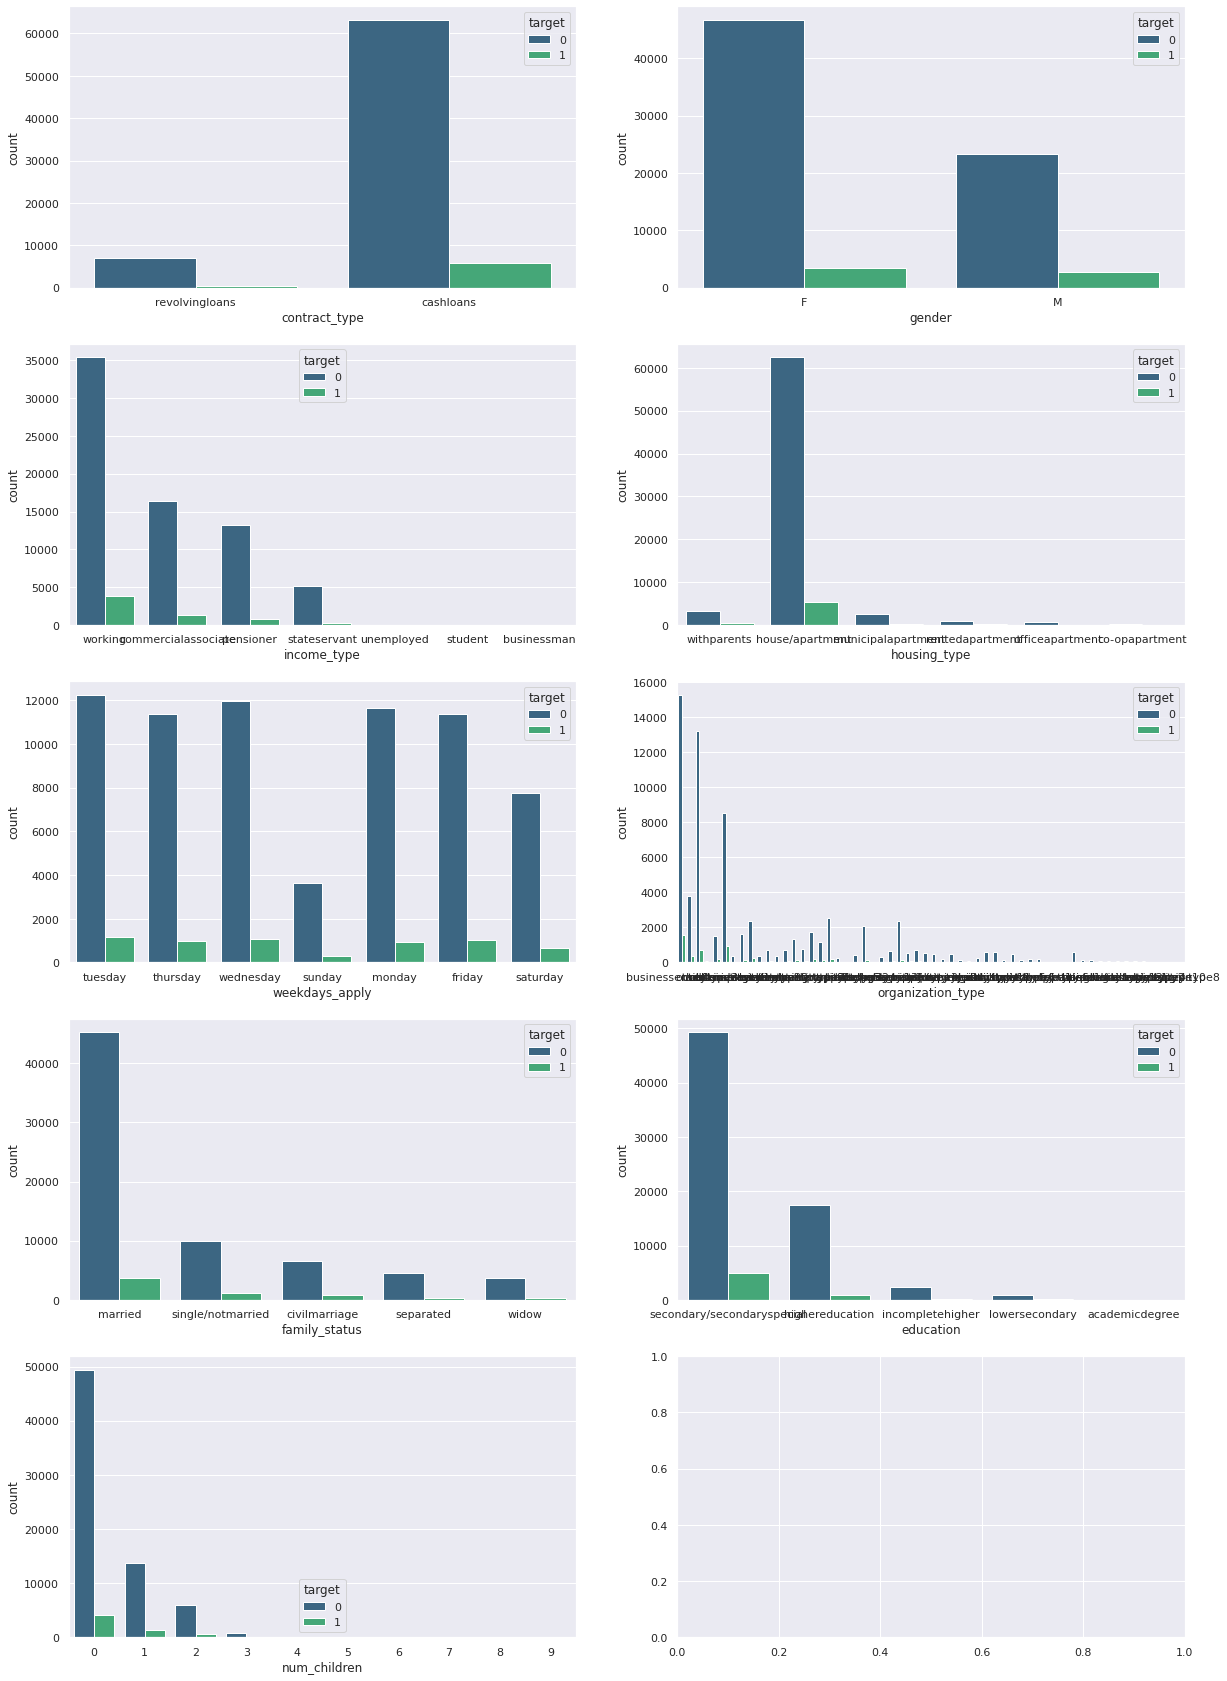

In [43]:
### Data Visualization 
categorical_columns = [
    'contract_type', 'gender', 'income_type', 'housing_type', 'weekdays_apply',
    'organization_type', 'family_status', 'education', "num_children"
]

fig,axes = plt.subplots(5,2,figsize=(20,30))

for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=data_loan,hue='target',ax=axes[row,col], palette = 'viridis')



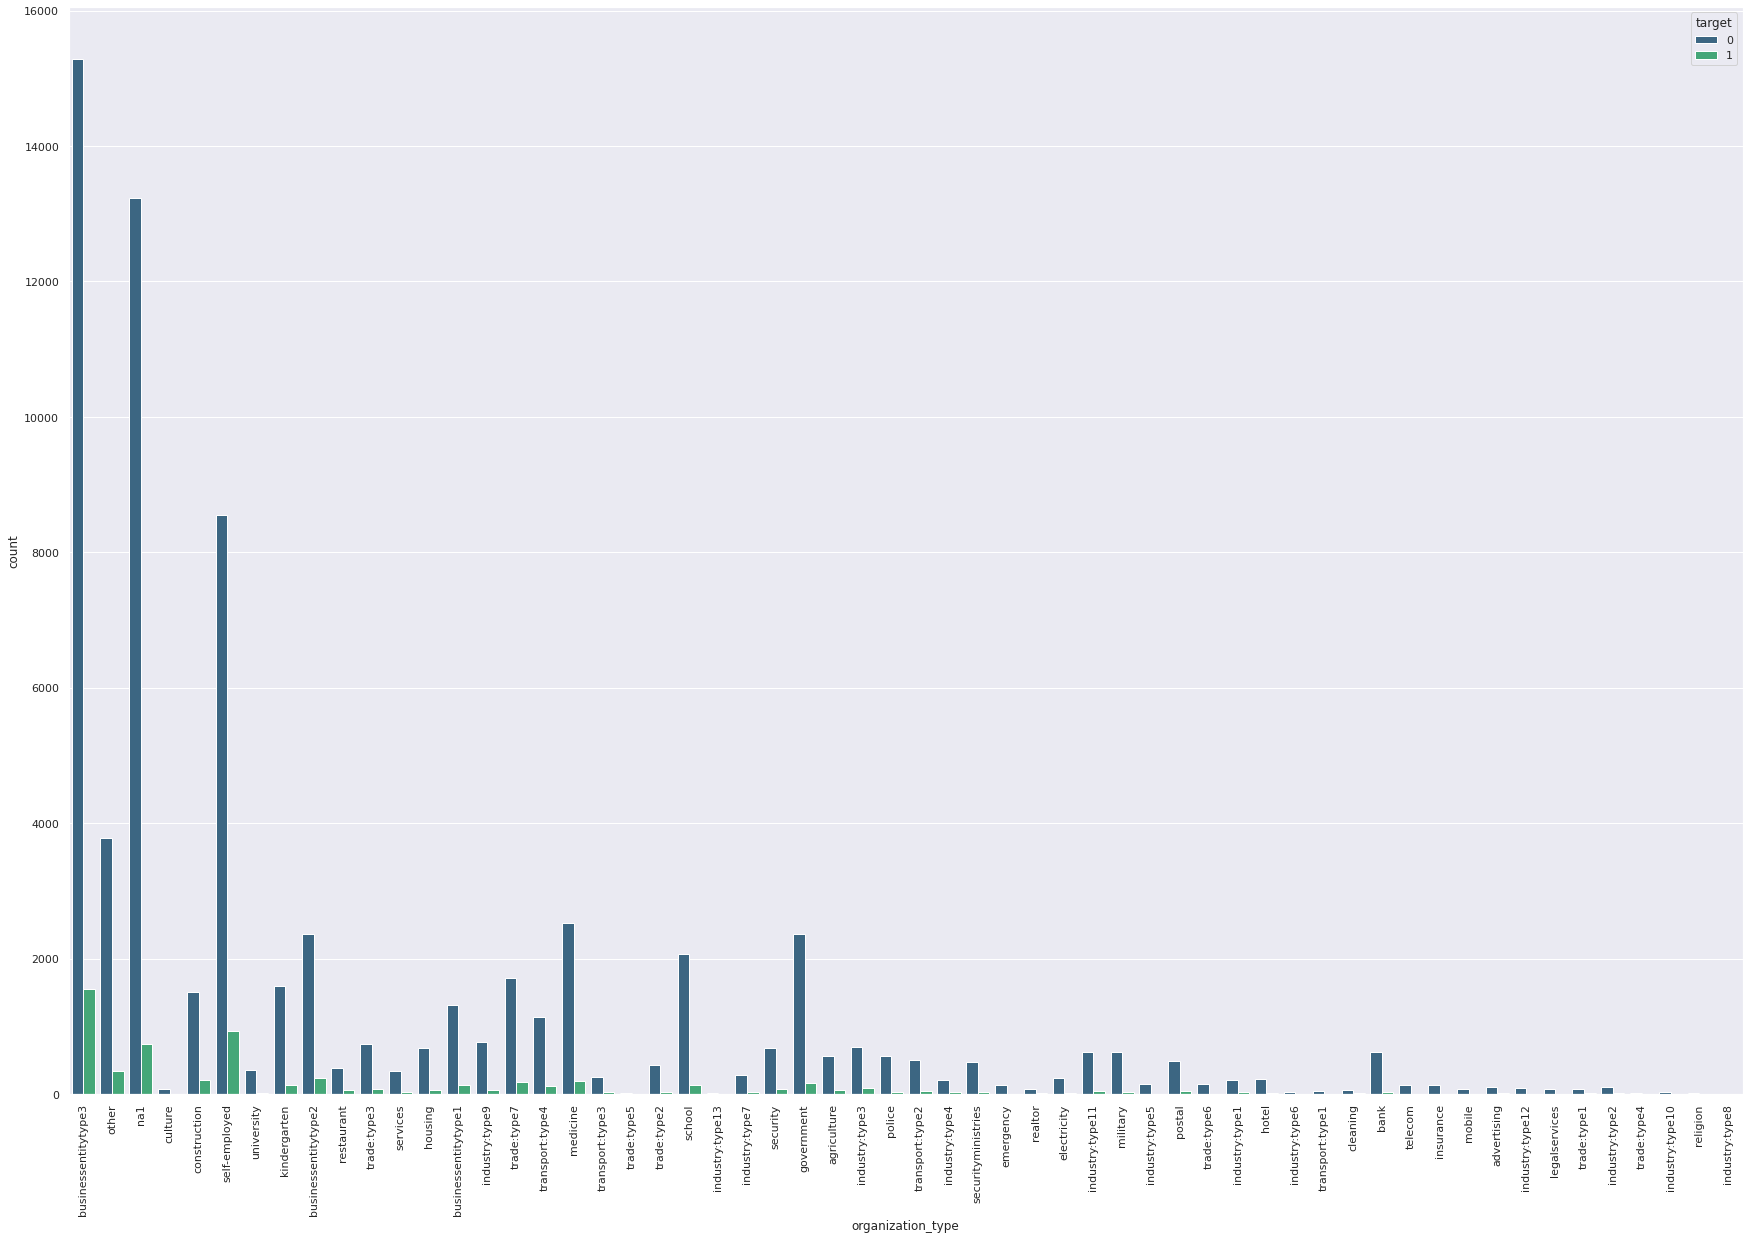

In [88]:
# Detail from column organization_type
plt.subplots(figsize=(30,20))
plt.xticks(rotation=90)
sns.countplot(x=data_loan.organization_type,data=data_loan,hue='target', palette = 'viridis')


1. In the contract_type column: customers prefer cash loans over revolving loans, the difference is quite significant between the two which in this case can discuss cash loans, but revolving loans are also given attractive offers.
2. In the gender column: it is stated that from a population of around 70:30, the majority are held by women who often borrow with timely payments, but the potential for repayment is slightly different between women and men.
3. In the income_type column: 1/2 of the population borrowing from our company is mostly by customers with working income.
4. housing_type: in this column alone 9/10 of the population is dominated by customers who live with the type of house/apartment.
5. weekdays_apply: quite balanced our customers who apply to borrow Monday - Friday, it's only natural because these 5 days are normal which allows workers to take it on normal days, but Saturday and Sunday are holidays for workers who want to borrow money, but also there is a factor from borrowing an office that is not open on holidays.
6. organization_type: many organizations that need credit for their liabilities so that more assets are obtained to maintain cash flow. In this case, it is natural that the type 3 entity business dominates in the population.
7. family_status: married status dominates about 3/4 of the population but the possibility of late is very significantly different. It is necessary to pay attention to the status of single/unmarried and civil marital status where the two statuses are not much different in the probability of payment at the time of late payment.
8. education: secondary dominates the entire population, the higher the education level, the smaller the probability of borrowing from customers.
9. num_children: it is quite clear that the customers who dominate the loan are those who do not have children. It's natural that they still don't have high responsibilities, so they dare to take risks to borrow money for their needs like teenagers.

from all the column categories above, the possibility of late paying is small or significantly different from customers who pay on time, but more attention is paid to organization_type which is more stringent for the payment period because many allow late payments.

### Data Visualization for correlation 

Text(0.5, 1.0, 'Income vs Approved Credit')

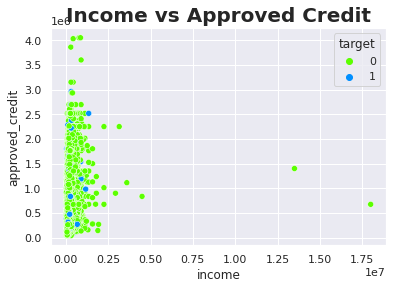

In [46]:
# Income vs Approved Credit
sns.scatterplot(x='income',y='approved_credit',hue='target', data=data_loan, palette='gist_rainbow')
plt.title('Income vs Approved Credit',fontweight="bold", size=20)

Text(0.5, 1.0, 'Income vs Annuity')

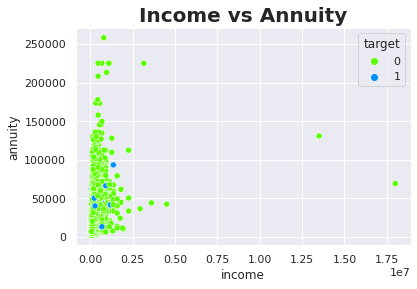

In [47]:
# Income vs Annuity
sns.scatterplot(x='income',y='annuity',hue='target', data=data_loan, palette='gist_rainbow')
plt.title('Income vs Annuity',fontweight="bold", size=20)

Text(0.5, 1.0, 'Income vs Price')

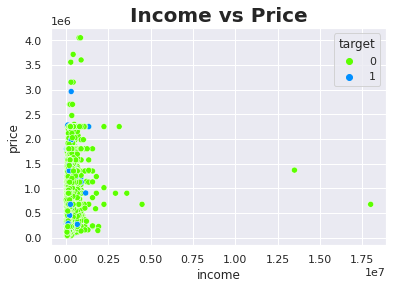

In [48]:
# Income vs Price
sns.scatterplot(x='income',y='price',hue='target', data=data_loan, palette='gist_rainbow')
plt.title('Income vs Price',fontweight="bold", size=20)

Text(0.5, 1.0, 'Approved Credit vs Annuity')

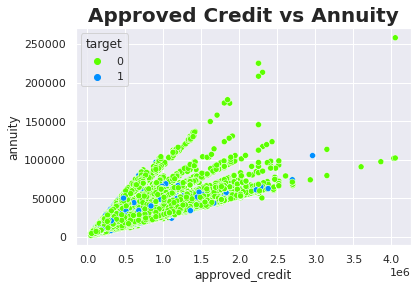

In [49]:
# approved_credit vs annuity
sns.scatterplot(x='approved_credit',y='annuity',hue='target', data=data_loan, palette='gist_rainbow')
plt.title('Approved Credit vs Annuity',fontweight="bold", size=20)

Text(0.5, 1.0, 'Approved Credit vs price')

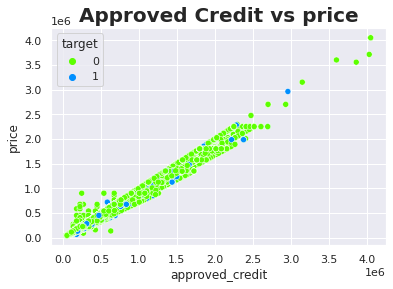

In [50]:
# approved_credit vs price
sns.scatterplot(x='approved_credit',y='price',hue='target', data=data_loan, palette='gist_rainbow')
plt.title('Approved Credit vs price',fontweight="bold", size=20)

Text(0.5, 1.0, 'Price vs Annuity')

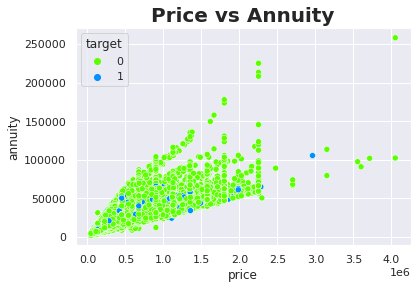

In [51]:
# price vs annuity
sns.scatterplot(x='price',y='annuity',hue='target', data=data_loan, palette='gist_rainbow')
plt.title('Price vs Annuity',fontweight="bold", size=20)

All of the graphs above, which are highly correlated with each other, do not stand out to determine which ones have the potential to be late paying loans, because we can see for ourselves that the scatter plot distribution itself is still overlapping which is subjective as humans cannot guess which ones will have the potential. will be late paying.

### Normalized score from external data source

Text(0.5, 1.0, 'Approved Credit vs ext_score_2')

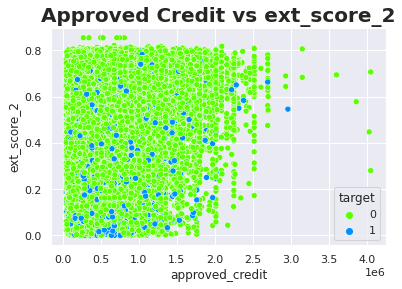

In [109]:
# Approved Credit vs ext_score_2
sns.scatterplot(x='approved_credit',y='ext_score_2',hue='target', data=data_loan, palette='gist_rainbow')
plt.title('Approved Credit vs ext_score_2',fontweight="bold", size=20)

As can be seen in the graph above, the distributions are still overlapping. However, if the client approves the credit with a score of < 0.5, you need to be careful because it has the potential to be late paying the loan, but it is possible if the score > 0.5 is not late paying. Therefore I will create a model that will predict clients who classify payments on time and late payments.

## Preprocessing

### Splitting Dataset

In [110]:
# Split between `X` (Features) dan `y` (target)

# Train set
X_train_loan = data_copy_loan_train.drop('target', axis=1)
y_train_loan = data_copy_loan_train['target']

# Test set 
X_test_loan = data_copy_loan_test.drop('target', axis=1)
y_test_loan = data_copy_loan_test["target"]

print("Training data shape: {}".format(X_train_loan.shape))
print("Testing data shape: {}".format(X_test_loan.shape))

Training data shape: (61503, 20)
Testing data shape: (14761, 20)


### Handling Missing Value

In [111]:
# check missing values in train set
check_missing(X_train_loan)

,feats,tot_missing,tot_missing_pct
0,ext_score_3,12239,1.99e+01
1,ext_score_2,134,2.18e-01
2,price,62,1.01e-01
3,annuity,1,1.63e-03


In data train set there's much missing value on EXT_SCORE_3 almost 20% distribution have NaN. Column X_train_loan is that persentation behavior for our client that can pay the loan, we should have handle that, but the value is float and the meaning of column is rating each client, the columns EXT_SCORE_2 and EXT_SCORE_3 will be fillna by median. Same like before, for columns PRICE and ANNUITY will fillna by median to.

In [112]:
# check missing values in test set
check_missing(X_test_loan)

,feats,tot_missing,tot_missing_pct
0,ext_score_3,2919,19.78
1,price,20,0.14
2,ext_score_2,19,0.13


In data test set we can see there's no missing value on column Annuity, so we just handle 3 columns as we can see from above.

In [113]:
# display missing values in train set
X_train_loan[X_train_loan.isna().any(axis=1)]

,contract_type,gender,num_children,income,approved_credit,annuity,price,income_type,education,family_status,housing_type,days_age,days_work,days_registration,days_id_change,weekdays_apply,hour_apply,organization_type,ext_score_2,ext_score_3
0,revolvingloans,F,1,67500.0,202500.0,10125.0,202500.0,working,secondary/secondaryspecial,married,withparents,-11539,-921,-119.0,-2757,tuesday,18,businessentitytype3,0.61,NaN
1,cashloans,F,1,202500.0,976711.5,49869.0,873000.0,commercialassociate,secondary/secondaryspecial,married,house/apartment,-15743,-4482,-1797.0,-2455,tuesday,14,other,0.68,NaN
13,cashloans,M,0,202500.0,835380.0,42651.0,675000.0,pensioner,secondary/secondaryspecial,separated,house/apartment,-20850,365243,-7511.0,-3877,tuesday,15,na1,0.61,NaN
22,revolvingloans,F,0,135000.0,270000.0,13500.0,270000.0,working,secondary/secondaryspecial,single/notmarried,house/apartment,-20143,-2572,-614.0,-2091,tuesday,11,businessentitytype3,0.33,NaN
42,cashloans,M,0,202500.0,90000.0,9580.5,90000.0,working,secondary/secondaryspecial,married,house/apartment,-11342,-335,-564.0,-3917,monday,17,industry:type9,0.39,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61489,cashloans,M,0,247500.0,450000.0,23562.0,450000.0,working,secondary/secondaryspecial,single/notmarried,withparents,-11098,-1088,-1156.0,-278,tuesday,15,self-employed,0.59,NaN
61492,cashloans,F,0,90000.0,675000.0,28597.5,675000.0,commercialassociate,secondary/secondaryspecial,married,house/apartment,-14453,-5782,-4153.0,-3944,friday,8,businessentitytype3,0.42,NaN
61495,cashloans,M,2,157500.0,123993.0,8518.5,103500.0,working,secondary/secondaryspecial,single/notmarried,rentedapartment,-12500,-972,-1677.0,-3862,tuesday,5,military,0.66,NaN
61496,cashloans,F,0,180000.0,630747.0,22783.5,544500.0,commercialassociate,secondary/secondaryspecial,single/notmarried,house/apartment,-19873,-431,-4732.0,-2623,wednesday,11,self-employed,0.51,NaN


Total we should have fill NaN with median for train-set is 12381 rows.

In [114]:
# display missing values in train set
X_test_loan[X_test_loan.isna().any(axis=1)]

,contract_type,gender,num_children,income,approved_credit,annuity,price,income_type,education,family_status,housing_type,days_age,days_work,days_registration,days_id_change,weekdays_apply,hour_apply,organization_type,ext_score_2,ext_score_3
1,cashloans,F,0,144000.0,4.86e+05,34537.5,4.50e+05,working,highereducation,married,officeapartment,-14097,-7408,-7908.0,-4872,monday,14,kindergarten,0.68,NaN
6,cashloans,F,2,90000.0,2.61e+05,18666.0,2.25e+05,working,highereducation,married,house/apartment,-11658,-4198,-2043.0,-4206,monday,15,businessentitytype2,0.46,NaN
12,cashloans,F,0,247500.0,1.12e+06,62950.5,1.12e+06,working,secondary/secondaryspecial,married,house/apartment,-19711,-2671,-582.0,-3182,wednesday,9,businessentitytype3,0.78,NaN
14,cashloans,F,0,54000.0,9.59e+04,9486.0,9.00e+04,working,secondary/secondaryspecial,married,house/apartment,-17256,-230,-8428.0,-791,tuesday,15,kindergarten,0.39,NaN
16,cashloans,F,1,180000.0,1.34e+06,43389.0,1.34e+06,commercialassociate,highereducation,married,house/apartment,-11073,-651,-487.0,-2331,tuesday,14,self-employed,0.67,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14731,cashloans,F,1,202500.0,1.64e+06,44995.5,1.46e+06,stateservant,secondary/secondaryspecial,married,municipalapartment,-13335,-5049,-4833.0,-4825,tuesday,14,medicine,0.76,NaN
14733,cashloans,F,1,202500.0,3.13e+05,33885.0,2.84e+05,working,secondary/secondaryspecial,married,house/apartment,-12728,-2046,-3382.0,-5158,tuesday,11,self-employed,0.55,NaN
14746,cashloans,M,1,220500.0,7.65e+05,24678.0,7.65e+05,working,secondary/secondaryspecial,married,withparents,-9205,-1621,-2154.0,-1888,monday,10,businessentitytype3,0.20,NaN
14749,cashloans,F,1,81000.0,6.79e+05,28917.0,5.49e+05,working,secondary/secondaryspecial,civilmarriage,house/apartment,-16456,-8534,-2129.0,-4,tuesday,9,government,0.16,NaN


And total we should have fill NaN with median for train-set is 2948 rows.

In [115]:
# define median for train set
median1 = X_train_loan["ext_score_3"].median()
median2 = X_train_loan["ext_score_2"].median()
median3 = X_train_loan["price"].median()
median4 = X_train_loan["annuity"].median()

# define median for test set
median5 = X_test_loan["ext_score_3"].median()
median6 = X_test_loan["ext_score_2"].median()
median7 = X_test_loan["price"].median()

In [116]:
# fillna median for trainset
# impute missing values in `minimum_payments` with `payments`
X_train_loan["ext_score_3"] = X_train_loan["ext_score_3"].fillna(median1)
X_train_loan["ext_score_2"] = X_train_loan["ext_score_2"].fillna(median2)
X_train_loan["price"] = X_train_loan["price"].fillna(median3)
X_train_loan["annuity"] = X_train_loan["annuity"].fillna(median4)

# fillna median for testset
X_test_loan["ext_score_3"] = X_test_loan["ext_score_3"].fillna(median5)
X_test_loan["ext_score_2"] = X_test_loan["ext_score_2"].fillna(median6)
X_test_loan["price"] = X_test_loan["price"].fillna(median7)

### Categorizing Features

Categorize the features based on the variable type of the features and the data it represents
- Numeric (Interval): Features which have equally spaced interval between unique values
- Categorical (Nominal): Features which have no intrinsic ordering to the unique values
- Ordinal: Features which have clear ordering but do not have equally spaced intervals between unique values

In [122]:
X_train_loan.head(5)

,contract_type,gender,num_children,income,approved_credit,annuity,price,income_type,education,family_status,housing_type,days_age,days_work,days_registration,days_id_change,weekdays_apply,hour_apply,organization_type,ext_score_2,ext_score_3
0,revolvingloans,F,1,67500.0,202500.0,10125.0,202500.0,working,secondary/secondaryspecial,married,withparents,-11539,-921,-119.0,-2757,tuesday,18,businessentitytype3,0.61,0.54
1,cashloans,F,1,202500.0,976711.5,49869.0,873000.0,commercialassociate,secondary/secondaryspecial,married,house/apartment,-15743,-4482,-1797.0,-2455,tuesday,14,other,0.68,0.54
2,cashloans,F,0,180000.0,407520.0,25060.5,360000.0,pensioner,secondary/secondaryspecial,married,house/apartment,-20775,365243,-8737.0,-4312,thursday,14,na1,0.58,0.75
3,cashloans,M,0,225000.0,808650.0,26086.5,675000.0,stateservant,highereducation,married,house/apartment,-20659,-10455,-4998.0,-4010,wednesday,10,culture,0.62,0.71
4,revolvingloans,M,0,135000.0,180000.0,9000.0,180000.0,commercialassociate,secondary/secondaryspecial,single/notmarried,house/apartment,-9013,-1190,-3524.0,-1644,sunday,11,construction,0.49,0.09


In [123]:
X_train_loan.columns

Index(['contract_type', 'gender', 'num_children', 'income', 'approved_credit',
       'annuity', 'price', 'income_type', 'education', 'family_status',
       'housing_type', 'days_age', 'days_work', 'days_registration',
       'days_id_change', 'weekdays_apply', 'hour_apply', 'organization_type',
       'ext_score_2', 'ext_score_3'],
      dtype='object')

In [124]:
# categorizing features
num_cols = [
    'income', 'approved_credit',  'annuity', 'price', 
    'days_age', 'days_work', 'days_registration', 'days_id_change',
    'hour_apply', 'ext_score_2', 'ext_score_3'
]

nom_cols = [
    'contract_type', 'gender', 'income_type', 'housing_type', 'weekdays_apply',
    'organization_type', 'family_status', 'num_children'
]

ord_cols = ['education']

### Handling Outliers

In [125]:
# check outlier summary only on numerical features
outlier_summary(X_train_loan[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,income,56.67,skewed,2853,4.64
1,approved_credit,1.23,skewed,1302,2.12
2,annuity,1.56,skewed,1504,2.45
3,price,1.34,skewed,2941,4.78
4,days_age,-0.11,normal,0,0.00
5,days_work,1.64,skewed,14516,23.60
6,days_registration,-0.58,skewed,129,0.21
7,days_id_change,0.35,normal,0,0.00
8,hour_apply,-0.02,normal,119,0.19
9,ext_score_2,-0.79,skewed,0,0.00


1. `Trimming`: if outliers' percentage < 5%
2. `Capping`: if outliers' percentage 5% - 15%
3. `Trimming and Capping`: if outliers' percentage > 15%

In [126]:
# check outlier details
check_outlier(X_train_loan[num_cols], 1.5)

,feats,upper_bound,lower_bound,tot_right_tail,tot_left_tail,tot_right_tail_pct,tot_left_tail_pct,tot_outlier,tot_outlier_pct
0,income,3.38e+05,-22500.00,2853,0,4.64,0.00,2853,4.64
1,approved_credit,1.62e+06,-537975.00,1302,0,2.12,0.00,1302,2.12
2,annuity,6.17e+04,-10629.00,1504,0,2.45,0.00,1504,2.45
3,price,1.34e+06,-423000.00,2941,0,4.78,0.00,2941,4.78
4,days_age,-2.97e+03,-29148.09,0,0,0.00,0.00,0,0.00
5,days_work,3.45e+03,-6488.50,11253,3263,18.30,5.31,14516,23.60
6,days_registration,6.23e+03,-15703.50,0,129,0.00,0.21,129,0.21
7,days_id_change,1.54e+03,-7533.60,0,0,0.00,0.00,0,0.00
8,hour_apply,2.19e+01,2.24,44,75,0.07,0.12,119,0.19
9,ext_score_2,1.07e+00,-0.01,0,0,0.00,0.00,0,0.00


Trim and cap the outliers

In [127]:
# print X_train_loan and y_train_loan shape before trimming and capping
print('X_train_loan shape before trimming and capping:', X_train_loan.shape)
print('y_train_loan shape before trimming and capping:', y_train_loan.shape)

# trim and cap outliers
X_train_loan, y_train_loan = trim_cap_outliers(
    X_train_loan,
    exception_list = nom_cols + ord_cols,
    distance=1.5,
    target=y_train_loan
)

# print X_train_loan and y_train_loan shape after trimming and capping
print('X_train_loan shape after trimming and capping:', X_train_loan.shape)
print('y_train_loan shape after trimming and capping:', y_train_loan.shape)

X_train_loan shape before trimming and capping: (61503, 20)
y_train_loan shape before trimming and capping: (61503,)
X_train_loan shape after trimming and capping: (54698, 20)
y_train_loan shape after trimming and capping: (54698,)


Dataset has been trim, trainset there's much trim on distribution data.

### Feature Selection

#### Heatmap Correlation Matrix for Numerical Features

We look at the Target correlation matrix to find out the relation between features and target

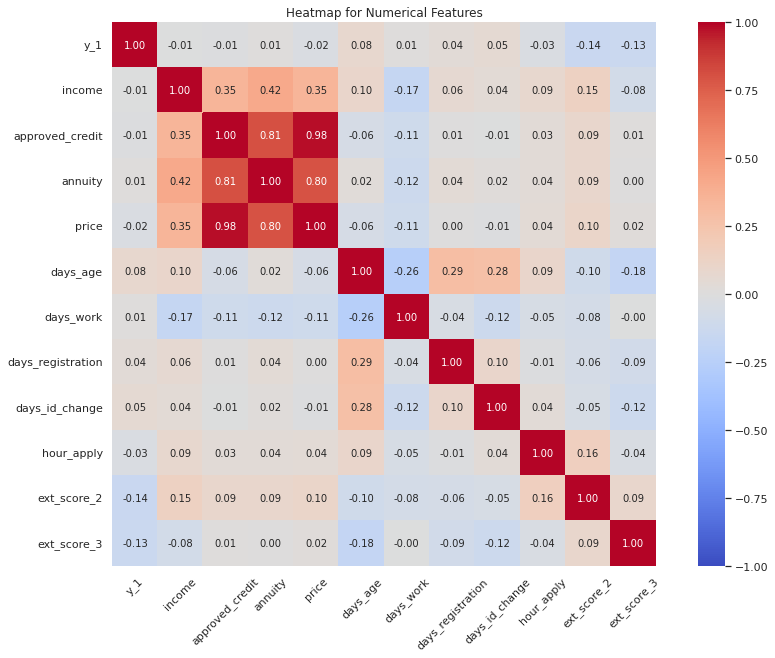

In [128]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([
        pd.get_dummies(y_train_loan, prefix='y', drop_first=True),
        X_train_loan[num_cols]], axis=1
    ).corr('spearman'),
    annot=True, vmin=-1, vmax=1, fmt='.2f', square=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Heatmap for Numerical Features')

plt.show()


- There is no high correlation between features with target
- High correlation between features 'INCOME, 'APPROVED_CREDIT', 'ANNUITY', and 'PRICE' they are dependent features for process payment loan
- Also high correlation between feature ratings "EXT_SCORE_2" and "EXT_SCORE_3" this features explain about client behavior base on history their payments
- I don't want to drop any features for this model

#### Categorizing Selected Features

In [129]:
# display outlier summary
outlier_summary(X_train_loan[num_cols], 1.5).sort_values(by='dist')

,feats,skew,dist,tot_outlier,tot_outlier_pct
4,days_age,-1.09e-01,normal,0,0.00
7,days_id_change,3.53e-01,normal,0,0.00
8,hour_apply,1.11e-03,normal,0,0.00
10,ext_score_3,-4.30e-01,normal,0,0.00
0,income,6.74e-01,skewed,1983,3.63
1,approved_credit,7.18e-01,skewed,59,0.11
2,annuity,5.83e-01,skewed,540,0.99
3,price,7.58e-01,skewed,0,0.00
5,days_work,1.57e+00,skewed,13364,24.43
6,days_registration,-5.33e-01,skewed,0,0.00


In [131]:
# create list of numerical features with normal distribution
num_cols_norm = [
    'days_age', 'days_id_change', 'hour_apply', 'ext_score_3'
]

# create list of numerical features with skew
num_cols_skew = [
    'income', 'approved_credit', 'annuity',
    'price', 'days_work', 'days_registration', 'ext_score_2', 'num_children'
]

nom_cols = [
    'contract_type', 'gender', 'income_type', 'housing_type', 'weekdays_apply',
    'organization_type', 'family_status'
]

ord_cols = ['education']

Great! We have finalized our feature list.
We also separated numerical features with different types of distribution just in case we want to scale them using different methods

#### List of Features

These are the predictors we're going to use

In [132]:
# print out list of predictors
print('Numerical Features:')
print(num_cols_norm + num_cols_skew)
print('=' * 100)
print('Categorical Features:')
print(nom_cols)
print('=' * 100)
print('Ordinal Features:')
print(ord_cols)

Numerical Features:
['days_age', 'days_id_change', 'hour_apply', 'ext_score_3', 'income', 'approved_credit', 'annuity', 'price', 'days_work', 'days_registration', 'ext_score_2', 'num_children']
Categorical Features:
['contract_type', 'gender', 'income_type', 'housing_type', 'weekdays_apply', 'organization_type', 'family_status']
Ordinal Features:
['education']


In [133]:
# prepare education ordered categorical variable
education_order = [
    "lowersecondary",
    "secondary/secondaryspecial",
    "incompletehigher",
    "highereducation",
    "academicdegree"
]

## Feature Engineering

### Prepare The Necessary Objects

Declare the various objects, like scaler and encoder we might use
- All categorical features will use one hot encoder
- Ordinal features which is `EDUCATION` will use ordinal encoder

In [134]:
# declare standard scaler
std_sc = StandardScaler()

# declare min max scaling
mm_sc = MinMaxScaler()

# declare one hot encoder
ohe_enc = OneHotEncoder(sparse=False)

# declare ordinal encoder
ord_enc = OrdinalEncoder(categories=[education_order])


Create ColumnTransformer, SMOTENC, and PCA objects In ColumnTransformer, we will design so that our dataset will have the categorical features lined up after the numerical ones

In [135]:
# create column transformer object using min max scaler
scale_mm = ColumnTransformer([
    ('num_norm', std_sc, num_cols_norm),
    ('num_skew', mm_sc, num_cols_skew),
    ('nom', 'passthrough', nom_cols),
    ('ord', 'passthrough', ord_cols)
])

# create column transformer object for use after oversampling
encode = ColumnTransformer([
    ('num', 'passthrough', slice(0, 12)),
    ('nom', ohe_enc, slice(12, 19)),
    ('ord', ord_enc, [19])
])

# create smotenc object
# categorical features will be put at the end, after the numerical ones
smotenc = SMOTENC(
    categorical_features= list(range(12, 20)),
    random_state=42
)


### Scaling

We need to scale all numerical columns before oversampling

In [136]:
# scale numeric features 
X_train_loan_scaled = scale_mm.fit_transform(X_train_loan)
X_test_loan_scaled = scale_mm.transform(X_test_loan)

# print shape
print('X_train_loan_scaled shape:', X_train_loan_scaled.shape)
print('X_test_loan_scaled shape:', X_test_loan_scaled.shape)


X_train_loan_scaled shape: (54698, 20)
X_test_loan_scaled shape: (14761, 20)


### Oversampling

Since our data is imbalance, we need to perform oversampling

In [137]:
# oversampling using SMOTE
X_train_loan_balanced, y_train_loan_balanced = smotenc.fit_resample(X_train_loan_scaled, y_train_loan)

# print shape after oversampling
print('X_train_loan_balanced shape:', X_train_loan_balanced.shape)
print('y_train_loan_balanced shape:', y_train_loan_balanced.shape)

X_train_loan_balanced shape: (100482, 20)
y_train_loan_balanced shape: (100482,)


### Encoding

In [138]:
# encode categorical features
X_train_loan_encoded = encode.fit_transform(X_train_loan_balanced)
X_test_loan_encoded = encode.transform(X_test_loan_scaled)


# print shape
print('X_train_loan_encoded shape:', X_train_loan_encoded.shape)
print('X_test_loan_encoded shape:', X_test_loan_encoded.shape)

X_train_loan_encoded

X_train_loan_encoded shape: (100482, 99)
X_test_loan_encoded shape: (14761, 99)


array([[1.0272635513164003, 0.1610886428416802, 1.858556510136953, ...,
        0.0, 0.0, 1.0],
       [0.07452620345540627, 0.36112120963021405, 0.6185629261465762,
        ..., 0.0, 0.0, 1.0],
       [-1.0658577961726912, -0.868880368271466, 0.6185629261465762, ...,
        0.0, 0.0, 1.0],
       ...,
       [1.3050705859247234, 1.76656104219633, -0.4699381501040455, ...,
        1.0, 0.0, 1.0],
       [1.4301789206862152, 0.3681838458218876, 2.2289373321687025, ...,
        0.0, 0.0, 1.0],
       [0.9217527131827318, -0.02974212608361235, 0.30856453014898194,
        ..., 0.0, 0.0, 1.0]], dtype=object)

After encoding the fetures is so many, so i think we should reduction with pca

### Dimensionality Reduction

In [139]:
# create pca object
# declare PCA object using the whole features
pca = PCA(random_state=42)
pca.fit(X_train_loan_encoded)

# calculate cumulative sum of the explained variance ratio
cumsum = np.cumsum(pca.explained_variance_ratio_)

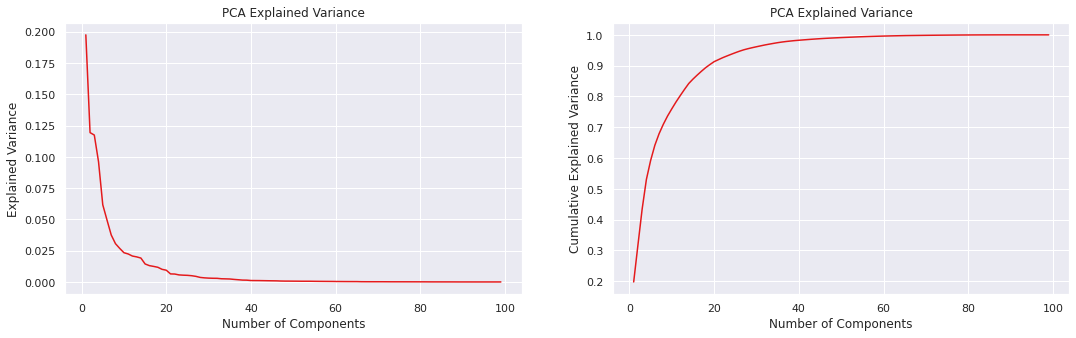

In [140]:
# plot the explained variance ratio
plt.figure(figsize=(18, 5))

# plot the explained variance ratio
plt.subplot(1, 2, 1)
plt.plot(range(1, X_train_loan_encoded.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')

# plot the cumulative sum of the explained variance ratio
plt.subplot(1, 2, 2)
plt.plot(range(1, X_train_loan_encoded.shape[1]+1), cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

plt.show()

Base on graph EVR, we can take 20 features or 90% information for this model is enough.

In [141]:
# declare PCA object with the preserve ratio of 0.9
pca = PCA(n_components=0.9, random_state=42)

# perform dimensionality reduction
X_reduced = pca.fit_transform(X_train_loan_encoded)

In [142]:
# display the number of components after dimensionality reduction
pca.n_components_

19

In [143]:
# perform dimensionality reduction
X_train_loan_final = pca.fit_transform(X_train_loan_encoded)
X_test_loan_final = pca.transform(X_test_loan_encoded)

# print shape
print('X_train_loan_final shape:', X_train_loan_final.shape)
print('y_train_loan shape:', y_train_loan_balanced.shape)
print('X_test_loan_final shape:', X_test_loan_final.shape)
print('y_test_loan shape:', y_test_loan.shape)


X_train_loan_final shape: (100482, 19)
y_train_loan shape: (100482,)
X_test_loan_final shape: (14761, 19)
y_test_loan shape: (14761,)


Well the features has been reduction just have 19 features with 90% will take for modeling, it is good compression.

Let's see how it would look like in 2D

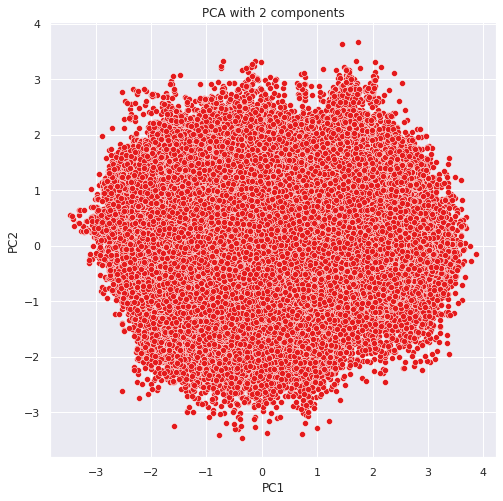

In [ ]:
# plot pca with 2 components
pca_2d = PCA(n_components=2, random_state=42)
X_2d  = pca_2d.fit_transform(encode.fit_transform(X_train_loan_balanced))

plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with 2 components')
plt.show()

Preprocessing is finished

## Model Definition

- Target: Predicting whether clients will pay to a term loan

    The target that we're going to predict is a label, which means we are going to make a classification model.
    In this case, we want to minimize the situation in which we incorrectly predicts a client won't pay (when the client is in fact will), or as in the statistical term, **False Negatives**.\
    This prediction is made so that we can target our clients and prioritize contacting those who have a high chance of subscribing. We don't want to classify a client as not potential when in fact, they should be contacted right away.

- Models: The Supervised Learning Algorithms I'm going to test
    - Logistic Regression
    - Support Vector Machine
    - Random Forest
    - XGBoost

In [ ]:
# declare logreg model
logreg = LogisticRegression(random_state=42)

# declare svm model
svm = SVC(random_state=42)

# declare random forest model
rf = RandomForestClassifier(random_state=42)

# declare xgboost model
xgb = XGBClassifier(random_state=42, eval_metric='error')

## Model Training

In [ ]:
# create a dictionary of models
models = {
    'logreg': logreg,
    'svm': svm,
    'rf': rf,
    'xgb': xgb
}

In [ ]:
models.items()

dict_items([('logreg', LogisticRegression(random_state=42)), ('svm', SVC(random_state=42)), ('rf', RandomForestClassifier(random_state=42)), ('xgb', XGBClassifier(eval_metric='error', random_state=42))])

### Cross Validating Base Models

Since the dataset is imbalance, we are going to evaluate our models based on **F1 Score**\
It's also important that we reduce the number of *False Negatives*, hence a high **Recall** is also important

In [ ]:
# create a dict to store the cross validation scores
cv_results = {
    'models': [],
    'f1_score_mean': [],
    'f1_score_std': [],
    'recall_score_mean': [],
    'recall_score_std': []
} 

# loop over each each models and perform cross validation
for name, model in models.items():
    # fit the model
    model.fit(X_train_loan_final, y_train_loan_balanced)
    # get cross validation scores
    scores = cross_validate(
        model, X_train_loan_final, y_train_loan_balanced,
        scoring=['f1_weighted', 'recall'],
        cv=3
    )

    # store the cross validation scores
    cv_results['models'].append(name)
    cv_results['f1_score_mean'].append(scores['test_f1_weighted'].mean().round(2))
    cv_results['f1_score_std'].append(scores['test_f1_weighted'].std().round(4))
    cv_results['recall_score_mean'].append(scores['test_recall'].mean().round(2))
    cv_results['recall_score_std'].append(scores['test_recall'].std().round(4))

# create a dataframe from the dict
cv_results_df = pd.DataFrame(cv_results)

## Model Evaluation

In [ ]:
# display the dataframe sorted by f1 score
cv_results_df.sort_values(by=['f1_score_mean', 'recall_score_mean'], ascending=False)

,models,f1_score_mean,f1_score_std,recall_score_mean,recall_score_std
2,rf,0.86,0.03,0.88,0.07
1,svm,0.79,0.02,0.84,0.05
3,xgb,0.76,0.02,0.79,0.04
0,logreg,0.74,0.02,0.76,0.04


- Based on the cross validation score of `f1_weighted` and `recall` we can see that **Random Forest and XGBoost** are the top two
- For this research, because of time constraint and resources, we are going to finetune only one of our algorithm
- In this case, I'm going to choose **Random Forest**. However, be mindful that **SVM** should also be further delved into but SVM take a long running time time,
- Random Forest is the best model for imbalance dataset because on the model have a many parameters, and can more train more deep because the depth parameter.

### Hyperparameter Tuning Random Forest

In [ ]:
# create parameter grid for random forest
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, 25],
    'max_features': [1, 2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf' : [4, 8],
    'n_estimators' : [300, 400, 500]
}

In [ ]:
# create randomized search object
rs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3, n_jobs=5, 
    verbose=True
)

In [ ]:
# %%time

# # perform randomized search
# rs.fit(X_train_loan_final, y_train_loan_balanced)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
CPU times: user 6min 47s, sys: 8.9 s, total: 6min 56s
Wall time: 4h 11min 56s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=5,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 25], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [4, 8],
                         'min_samples_split': [2, 4],
                         'n_estimators': [300, 400, 500]},
             scoring='f1_weighted', verbose=True)

In [ ]:
# print the best parameters
print(f'Best parameters: {rs.best_params_}')

# print the best score
print(f'Best score: {rs.best_score_:.4f}')

Best parameters: {'criterion': 'entropy', 'max_depth': 25, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Best score: 0.8493


In [ ]:
# assign the best estimator to the final model
grid_rf = rs.best_estimator_

Running this grid search resulted in:
- Best parameters: `{'criterion': 'entropy', 'max_depth': 25, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}`
- Best score: `0.8493`

### Model Improvement Random Forest

In [ ]:
# Improvement with class weight each target
class_weight = dict({0:0.4, 1:0.6})
rf_improve = RandomForestClassifier(bootstrap=True,            
                             class_weight=class_weight, 
                             criterion='entropy',
                             max_depth=25, max_features=3, max_leaf_nodes=None,         
                             min_impurity_decrease=0.0, 
                             min_samples_leaf=4, min_samples_split=2, 
                             min_weight_fraction_leaf=0.0, n_estimators=500,
                             oob_score=False,
                             random_state=42,
                             verbose=0, warm_start=False)

In [ ]:
%%time

# perform randomized search
rf_improve.fit(X_train_loan_final, y_train_loan_balanced)

CPU times: user 5min 47s, sys: 523 ms, total: 5min 47s
Wall time: 5min 46s


RandomForestClassifier(class_weight={0: 0.4, 1: 0.6}, criterion='entropy',
                       max_depth=25, max_features=3, min_samples_leaf=4,
                       n_estimators=500, random_state=42)

### Evaluate Hyperparameter Tuning Random Forset Results

#### Evaluate Random Forest Result

In [ ]:
# predict train set using the base model
y_pred_train_loan_rf = rf.predict(X_train_loan_final)

# predict test set using the base model
y_pred_test_loan_rf = rf.predict(X_test_loan_final)

# predict train set using the GridSearch CV model
y_pred_train_loan_grid_rf = grid_rf.predict(X_train_loan_final)

# predict test set using the GridSearch CV model
y_pred_test_loan_grid_rf = grid_rf.predict(X_test_loan_final)

# predict train set using the improvement model
y_pred_train_loan_rf_improve = rf_improve.predict(X_train_loan_final)

# predict test set using the improvement model
y_pred_test_loan_rf_improve = rf_improve.predict(X_test_loan_final)

In [ ]:
# prepare target names for classification report
target_names = ["On time Payment Loan", "Late Payment Loan"]

In [ ]:
# create a dictionary containing the list of base and final predictions
predictions = {
    'Base Random Forest': [y_pred_train_loan_rf, y_pred_test_loan_rf],
    'Final Random Forest': [y_pred_train_loan_grid_rf, y_pred_test_loan_grid_rf],
    'Improvment Random Forest': [y_pred_train_loan_rf_improve, y_pred_test_loan_rf_improve]
}

#### Summary of F1 and Recall Score

In [ ]:
# create a dict to store the classification report summarized
report_summary = {
    'models': [],
    'f1_scores_train': [],
    'f1_scores_test': [],
    'recall_scores_train': [],
    'recall_scores_test': [],
    'roc_auc_scores_train': [],
    'roc_auc_scores_test': []
} 

# loop over each each models and perform cross validation
for name, preds in predictions.items():
    # get f1 score training set
    f1_score_train = f1_score(y_train_loan_balanced, preds[0], average='weighted')
    # get f1 score test set
    f1_score_test = f1_score(y_test_loan, preds[1], average='weighted')
    # get recall score training set
    recall_score_train = recall_score(y_train_loan_balanced, preds[0], average='weighted')
    # get recall score test set
    recall_score_test = recall_score(y_test_loan, preds[1], average='weighted')
    # get roc auc score training set
    roc_auc_score_train = roc_auc_score(y_train_loan_balanced, preds[0], average='weighted')
    # get roc auc score test set
    roc_auc_score_test = roc_auc_score(y_test_loan, preds[1], average='weighted')

    # store the scores
    report_summary['models'].append(name)
    report_summary['f1_scores_train'].append(f1_score_train)
    report_summary['f1_scores_test'].append(f1_score_test)
    report_summary['recall_scores_train'].append(recall_score_train)
    report_summary['recall_scores_test'].append(recall_score_test)
    report_summary['roc_auc_scores_train'].append(roc_auc_score_train)
    report_summary['roc_auc_scores_test'].append(roc_auc_score_test)

# create a dataframe from the dict
report_summary_df = pd.DataFrame(report_summary)

In [ ]:
# display the report summary
report_summary_df

,models,f1_scores_train,f1_scores_test,recall_scores_train,recall_scores_test,roc_auc_scores_train,roc_auc_scores_test
0,Base Random Forest,1.00,0.84,1.00,0.83,1.00,0.56
1,Final Random Forest,0.96,0.83,0.96,0.81,0.96,0.57
2,Improvment Random Forest,0.95,0.82,0.95,0.79,0.95,0.57


- We can see from the comparison between the train score and the test score for each model to determine whether the model is a good fit
- We conclude that the base model is overfit as the f1 train score are way higher than the f1 test score
- The *Final Random Forest* method which have been tuned resulted in a good fit as the f1 and recall test scores are higher than their respective train scores counterpart.
- There's also not that much of a difference between the train and test scores
- Therefore, the *Final Random Forest* will be our main model to further analyze base on cross validation they give best result from standard deviasi and mean of recall and f1-score

#### Detailed Evaluation for Random Forest Classifier

In [ ]:
# print out the classification report for each model
for name, preds in predictions.items():
    print(f'\nClassification Report for {name} Training Set:')
    print(classification_report(y_train_loan_balanced, preds[0], target_names=target_names))
    print("="*100)
    print(f'\nClassification Report for {name} Test Set:')
    print(classification_report(y_test_loan, preds[1], target_names=target_names))
    print("="*100)


Classification Report for Base Random Forest Training Set:
                      precision    recall  f1-score   support

On time Payment Loan       1.00      1.00      1.00     50241
   Late Payment Loan       1.00      1.00      1.00     50241

            accuracy                           1.00    100482
           macro avg       1.00      1.00      1.00    100482
        weighted avg       1.00      1.00      1.00    100482


Classification Report for Base Random Forest Test Set:
                      precision    recall  f1-score   support

On time Payment Loan       0.93      0.88      0.90     13558
   Late Payment Loan       0.15      0.24      0.18      1203

            accuracy                           0.83     14761
           macro avg       0.54      0.56      0.54     14761
        weighted avg       0.86      0.83      0.84     14761


Classification Report for Final Random Forest Training Set:
                      precision    recall  f1-score   support

On time Pa

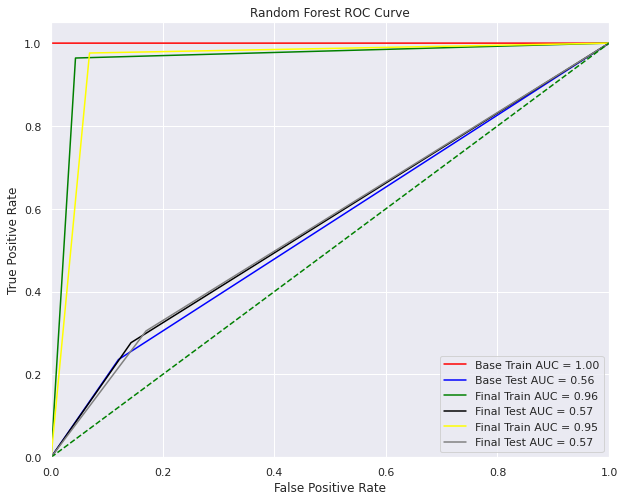

In [ ]:
# plot roc curve for train set
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train_loan_balanced, y_pred_train_loan_rf)
# calculate auc score for train set
roc_auc_train_rf = auc(fpr_train_rf, tpr_train_rf)

# plot roc curve for test set
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test_loan, y_pred_test_loan_rf)
# calculate auc score for test set
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

# plot roc curve for train set using the GridSearch CV model
fpr_train_grid_rf, tpr_train_grid_rf, _ = roc_curve(y_train_loan_balanced, y_pred_train_loan_grid_rf)
# calculate auc score for train set using the GridSearch model
roc_auc_train_grid_rf = auc(fpr_train_grid_rf, tpr_train_grid_rf)

# plot roc curve for test set using the GridSearch model
fpr_test_grid_rf, tpr_test_grid_rf, _ = roc_curve(y_test_loan, y_pred_test_loan_grid_rf)
# calculate auc score for test set using the GridSearch model
roc_auc_test_grid_rf = auc(fpr_test_grid_rf, tpr_test_grid_rf)

# plot roc curve for train set using the Improvement model
fpr_train_rf_improve, tpr_train_rf_improve, _ = roc_curve(y_train_loan_balanced, y_pred_train_loan_rf_improve)
# calculate auc score for train set using the Improvement model
roc_auc_train_rf_improve = auc(fpr_train_rf_improve, tpr_train_rf_improve)

# plot roc curve for test set using the Improvement model
fpr_test_rf_improve, tpr_test_rf_improve, _ = roc_curve(y_test_loan, y_pred_test_loan_rf_improve)
# calculate auc score for test set using the Improvement model
roc_auc_test_rf_improve = auc(fpr_test_rf_improve, tpr_test_rf_improve)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train_rf, tpr_train_rf, color='red', label=f'Base Train AUC = {roc_auc_train_rf:.2f}')
plt.plot(fpr_test_rf, tpr_test_rf, color='blue', label=f'Base Test AUC = {roc_auc_test_rf:.2f}')
plt.plot(fpr_train_grid_rf, tpr_train_grid_rf, color='green', label=f'Final Train AUC = {roc_auc_train_grid_rf:.2f}')
plt.plot(fpr_test_grid_rf, tpr_test_grid_rf, color='black', label=f'Final Test AUC = {roc_auc_test_grid_rf:.2f}')
plt.plot(fpr_train_rf_improve, tpr_train_rf_improve, color='yellow', label=f'Final Train AUC = {roc_auc_train_rf_improve:.2f}')
plt.plot(fpr_test_rf_improve, tpr_test_rf_improve, color='grey', label=f'Final Test AUC = {roc_auc_test_rf_improve:.2f}')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the classification report and the AUC score, we can see that tuning has made the model from overfit to a good fit. Hence viable to be run. However, we still need to look whether the metrics is good enough for our purpose
- We need to detect the potential of late payment as much as possible, therefore we need to minimize **False Negatives**, hence we need a high recall score
- We successfully increased the recall score after tuning and improvement, as we can see that we now have a recall score of `0.19` be `0.31` but this model is still bad. 
- This however, is not enough for us, as just having a few **False Negatives** could make us lose precious revenues
- Therefore, even though this model is now a good fit and we have successfully minimized the **False Negatives**, it is still not up to the standard needed and much improvements have to be made.
- The data distribution of target 1 so small so the machine cannot predict well from test set, even we do oversampling in trainset, just increse little bit recall, and f1-score.

## Model Save

We'll create a pipeline containing the steps performed post-oversampling to modeling



In [ ]:
# create a pipeline for the final model
final_rf_pipe = Pipeline([
    ('encode', encode),
    ('pca', pca),
    ('rf_improve', rf_improve)
])

# fit the pipeline to the imputed, scaled and oversampled training data
final_rf_pipe.fit(X_train_loan_balanced, y_train_loan_balanced)

Pipeline(steps=[('encode',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  slice(0, 12, None)),
                                                 ('nom',
                                                  OneHotEncoder(sparse=False),
                                                  slice(12, 19, None)),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['lowersecondary',
                                                                              'secondary/secondaryspecial',
                                                                              'incompletehigher',
                                                                              'highereducation',
                                                                              'academicdegree']]),
                                                  [19])])),
       

In [ ]:
# prepare directory for saving model
model_dir = 'models'
scaler_name = 'scale_mm.pkl'
model_name = 'final_rf_pipe.pkl'

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)

# save models
joblib.dump(scale_mm, Path(model_dir, scaler_name))
joblib.dump(final_rf_pipe, Path(model_dir, model_name))

['models/final_rf_pipe.pkl']

## Data Inference

In [ ]:
# sample dataset for inference
df_inf = data_copy_loan_train[data_copy_loan_train['target']==1].sample(10, random_state=42)
df_inf

,target,contract_type,gender,num_children,income,approved_credit,annuity,price,income_type,education,family_status,housing_type,days_age,days_work,days_registration,days_id_change,weekdays_apply,hour_apply,organization_type,ext_score_2,ext_score_3
11219,1,cashloans,F,0,135000.0,5.40e+05,19512.0,4.46e+05,pensioner,secondary/secondaryspecial,widow,house/apartment,-23671,365243,-12104.0,-3992,thursday,11,na1,0.62,NaN
45855,1,cashloans,F,0,135000.0,6.29e+05,30406.5,5.62e+05,working,highereducation,married,house/apartment,-13258,-1058,-1242.0,-2678,thursday,13,trade:type7,0.11,2.65e-01
57470,1,revolvingloans,F,0,90000.0,1.80e+05,9000.0,1.80e+05,working,secondary/secondaryspecial,married,house/apartment,-17721,-1226,-7220.0,-1260,tuesday,9,school,0.27,5.27e-04
54442,1,cashloans,F,0,157500.0,9.00e+05,46084.5,9.00e+05,working,secondary/secondaryspecial,married,house/apartment,-13232,-745,-843.0,-1679,saturday,9,businessentitytype3,0.45,3.98e-01
48593,1,cashloans,M,1,180000.0,1.01e+06,45630.0,9.00e+05,working,secondary/secondaryspecial,married,house/apartment,-15875,-1432,-618.0,-4537,wednesday,7,businessentitytype3,0.04,2.34e-01
28789,1,cashloans,M,0,270000.0,2.48e+05,11668.5,2.48e+05,working,secondary/secondaryspecial,married,withparents,-15963,-856,-2961.0,-1572,tuesday,18,trade:type7,0.56,3.89e-01
52932,1,cashloans,F,0,180000.0,1.30e+06,42187.5,1.14e+06,working,secondary/secondaryspecial,widow,house/apartment,-17454,-1850,-748.0,-1006,monday,14,self-employed,0.49,6.31e-01
32970,1,cashloans,F,2,135000.0,2.45e+05,16474.5,1.94e+05,working,secondary/secondaryspecial,married,house/apartment,-12526,-3460,-6672.0,-3987,tuesday,7,industry:type9,0.45,1.72e-01
4676,1,cashloans,M,0,180000.0,7.20e+05,48429.0,6.80e+05,working,secondary/secondaryspecial,married,house/apartment,-12155,-439,-960.0,-4291,friday,12,realtor,0.54,6.09e-01
37842,1,cashloans,M,0,135000.0,1.08e+06,31522.5,9.00e+05,working,secondary/secondaryspecial,single/notmarried,house/apartment,-10785,-743,-10785.0,-1024,tuesday,12,businessentitytype3,0.03,NaN


I will know performance the model if i use same data, that the model can predict or not?

In [ ]:
# Fill missing values with median
median = df_inf['ext_score_3'].median()
df_inf['ext_score_3'] = df_inf['ext_score_3'].fillna(median)

In [ ]:
# prepare data for inferencing
df_inf_prepared = df_inf.drop(columns=['target'])

# print shape of prepared data
df_inf_prepared.shape

(10, 20)

In [ ]:
%%time

# scale the inference set
df_inf_scaled = scale_mm.transform(df_inf_prepared)

# predict inference set using the final model
y_pred_inf = final_rf_pipe.predict(df_inf_scaled)

CPU times: user 59.7 ms, sys: 12 µs, total: 59.7 ms
Wall time: 58.4 ms


In [ ]:
# create dataframe with predictions
df_inf['pred'] = y_pred_inf

# display inference set
df_inf

,target,contract_type,gender,num_children,income,approved_credit,annuity,price,income_type,education,family_status,housing_type,days_age,days_work,days_registration,days_id_change,weekdays_apply,hour_apply,organization_type,ext_score_2,ext_score_3,pred
11219,1,cashloans,F,0,135000.0,5.40e+05,19512.0,4.46e+05,pensioner,secondary/secondaryspecial,widow,house/apartment,-23671,365243,-12104.0,-3992,thursday,11,na1,0.62,3.27e-01,0
45855,1,cashloans,F,0,135000.0,6.29e+05,30406.5,5.62e+05,working,highereducation,married,house/apartment,-13258,-1058,-1242.0,-2678,thursday,13,trade:type7,0.11,2.65e-01,1
57470,1,revolvingloans,F,0,90000.0,1.80e+05,9000.0,1.80e+05,working,secondary/secondaryspecial,married,house/apartment,-17721,-1226,-7220.0,-1260,tuesday,9,school,0.27,5.27e-04,0
54442,1,cashloans,F,0,157500.0,9.00e+05,46084.5,9.00e+05,working,secondary/secondaryspecial,married,house/apartment,-13232,-745,-843.0,-1679,saturday,9,businessentitytype3,0.45,3.98e-01,1
48593,1,cashloans,M,1,180000.0,1.01e+06,45630.0,9.00e+05,working,secondary/secondaryspecial,married,house/apartment,-15875,-1432,-618.0,-4537,wednesday,7,businessentitytype3,0.04,2.34e-01,1
28789,1,cashloans,M,0,270000.0,2.48e+05,11668.5,2.48e+05,working,secondary/secondaryspecial,married,withparents,-15963,-856,-2961.0,-1572,tuesday,18,trade:type7,0.56,3.89e-01,1
52932,1,cashloans,F,0,180000.0,1.30e+06,42187.5,1.14e+06,working,secondary/secondaryspecial,widow,house/apartment,-17454,-1850,-748.0,-1006,monday,14,self-employed,0.49,6.31e-01,1
32970,1,cashloans,F,2,135000.0,2.45e+05,16474.5,1.94e+05,working,secondary/secondaryspecial,married,house/apartment,-12526,-3460,-6672.0,-3987,tuesday,7,industry:type9,0.45,1.72e-01,1
4676,1,cashloans,M,0,180000.0,7.20e+05,48429.0,6.80e+05,working,secondary/secondaryspecial,married,house/apartment,-12155,-439,-960.0,-4291,friday,12,realtor,0.54,6.09e-01,1
37842,1,cashloans,M,0,135000.0,1.08e+06,31522.5,9.00e+05,working,secondary/secondaryspecial,single/notmarried,house/apartment,-10785,-743,-10785.0,-1024,tuesday,12,businessentitytype3,0.03,3.27e-01,1


Well my model have good predict, from target 1 in 10 rows successfully predict 8 of 10 it's really good, but not perfect there are bias.

## Conclusion

### On EDA

As we saw earlier in the EDA sub-chapter, many people dominate to become our clients to borrow funds. Prioritize those who dominate but be careful, the more clients who dominate to borrow, the bigger the brand for late payments. Therefore, we need to see that their previous behavior to owe from the ext_score is enough to explain that those who are < 0.5 a lot have the potential to be late in paying. Prioritize customers as follows:
1. Have relatively stable income or savings and do not have a **bad credit track record** in other borrowing companies base on ext_score_2 etc.
2. The client must have a **fixed income** so that it can be used as a benchmark for paying the loan, there is no reason for reduced income so late payments.
3. Prioritize those who dominate the charts in the EDA sub-chapter, and make attractive offers again for those who are in the minority.

### Implication

- Data imbalance sehingga kita tidak bisa melihat lebih spesifik siapa saja nasabah yang berpotensi telat bayar.
- Maka dari itu akan berdampak pada hasil model yang jelek karena perbedaan distribusi secara signifikan.

### On a Model

- Cross validation was carried out in order to find the best model between 4 models, namely Random Forest, Support Vector Machine, XGBoost, and Logistic Regression. Then trained with the oversampled X_train_loan_balanced, getting the average and standard deviation of the recall and f1-scored metrics.
- why refer to recall and f1-score? because here the data imbalance is suitable for metrics recall and f1-score, but what needs to be emphasized is recall in which this model must minimize the False Negative.
-Oversampling is done quite well with the training results, and model improvement is carried out by adding class weights that force the target to be a balanced weight value, enough to affect the results which increase the recall.
- We successfully increased Recall from the random forest import model but decreased accuracy, but in this case we are focused on minimizing False Negative results because it will be quite dangerous for the company if the biased model tends to False Negative it will be a loss.
- The Precision, Recall, an F1-Score can't be perfect because of imbalance dataset.
- ROC-AUC which shows the number 0.57 for the improvement model in the test-set, which means that the metrics still show this model is bad, due to the imbalance of the dataset.

### Future Improvements

- Mungkin perlu dicoba undersampling agar data seimbang dengan dataset yang real.
- Perlu dimodelkan dengan algoritma lainnya seperti Neural Network
- Membuat dataset real dengan target yang seimbang

# 2 - Answer Number 2

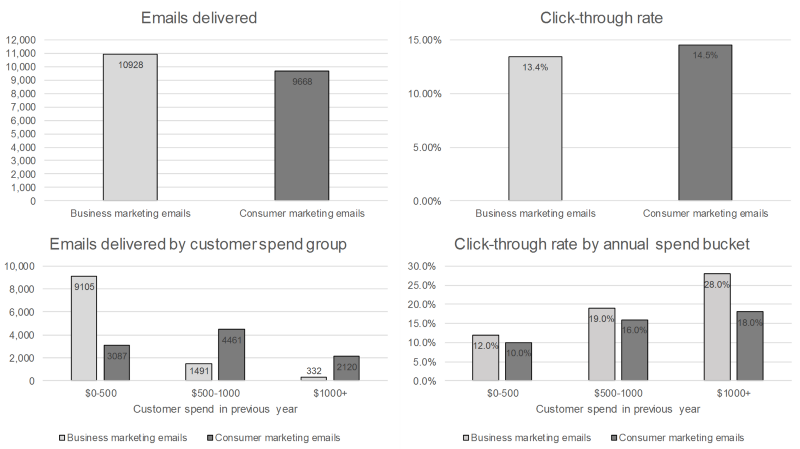

I think that enterprise software is better to focus on Consumer Marketing Emails for direct brand promotion to Consumers, on the graphics delivered and rates are not much different from business Email marketing strategies, but in the case of Consumer Marketing Emails it is much different. 

So how it works? To do this, you have to identify the target audience your company serves. Case in point, if a specific business deals with baby clothes, then its target audience primarily comprises mothers-to-be. Thus, it makes sense to use conventional means to get the email addresses of this demographic.

Segmenting is an effective tactic that allows you to send highly targeted email campaigns. With SendPulse, marketers can segment their mailing lists based on location, gender, occupation, age, behavior, etc. In turn, you can be sure that you are delivering appropriate and customized messages that appeal to customers.

There’s a great variety of different emails that marketers send. The choice of email style depends on the aim of each specific campaign. For example, if a user has just joined your mailing list, send them a welcome email. This is a great chance to explain the benefits of working with you. If clients have added some items to their shopping cart and didn’t buy them, send them an abandoned cart email to increase sales. Discover more about email campaign types.

To ensure that subscribers read your promotional emails, find out the best time for sending emails. It is, therefore, necessary to experiment and determine the time when subscribers are most engaged. A/B testing proves useful.

For email marketing to be a success, messages in promotional emails should be presented perfectly. Marketers should choose formats, fonts, and text sizes depending on the type of emails that they are creating. With SendPulse, you can use a drag-and-drop editor to create beautiful email templates that are customized to match your brand.

ith A/B testing, marketers can determine what copy of their email works best by swapping out different aspects of their email, such as subject lines (the most popular option), images, CTAs, headlines, offers, and so forth.

And last but not least adjusting your email strategy based on reports and feedback that you have gathered is the last step for developing an email marketing strategy. SendPulse provides users with a set of analytics that aids in gauging the effectiveness of email campaigns. Track email open rate, unsubscribe rate, click-through rates, email deliveries, email bounces, spam complaints, and more.

# 3 - Answer Number 3

In [149]:
# Define T-test for hypothesis testing
train_mean = np.mean(X_train_loan_final)
test_mean = np.mean(X_test_loan_final)

print("data_loan_train mean value:",train_mean)
print(" ")
print("data_loan_test mean value:",test_mean)
print("="*100)

train_std = np.std(X_train_loan_final)
test_std = np.std(X_test_loan_final)

print("data_loan_train std value:",train_std)
print(" ")
print("data_loan_test std value:",test_std)
print("="*100)

ttest,pval = ttest_ind(X_test_loan_final, X_train_loan_final)
print("p-value",pval)
print(" ")

if np.argmax(pval) < 0.05:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

data_loan_train mean value: 2.0447794553380503e-15
 
data_loan_test mean value: 0.024616075043288405
data_loan_train std value: 0.6293304298369029
 
data_loan_test std value: 0.6583611195561864
p-value [1.06272097e-087 4.72717612e-104 1.15465872e-003 8.04899652e-007
 5.51962787e-294 2.34741331e-079 2.25947246e-006 1.52121139e-009
 3.58991117e-001 1.40466328e-058 1.83526672e-001 6.29476148e-004
 8.30765748e-002 6.05692569e-001 1.50243569e-001 1.75328824e-066
 1.49415049e-044 8.38645220e-001 7.40543086e-115]
 
we accept null hypothesis



H0 : Data test == Data train
H1 : Data test != Data train

The t-test shows that the data is the same or accepts the null hypothesis, so there is no significant difference between the two data.

The main problem is that the predictions will be wrong ! The main reasons this can happen are loan late payment bias, and imbalance dataset on target.